In [1]:
import pandas as pd
import numpy as np
import pickle

import keras
import keras.utils

from keras.callbacks import TensorBoard
from keras import optimizers

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Dense,LSTM,Dropout,Bidirectional,GRU, Concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D

from keras.utils import to_categorical
from keras.layers import Flatten


from keras.utils import pad_sequences
from keras_preprocessing import sequence

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from keras.optimizers import SGD
from keras.regularizers import l2
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ModelCheckpoint


In [185]:
# columns = ['id','label','statement','subject','speaker','job-title','state','party','barely-true-counts','false-counts','half-true-counts','mostly-true-counts','pants-on-fire-counts','context']
# label_map = {'pants-fire':0, 'false':1, 'barely-true':2, 'half-true':3, 'mostly-true':4, 'true':5}
# # load v1 train_data from tsv
# train_data_TEMP = pd.read_csv('train.tsv', sep='\t', header=None, names=columns)

In [186]:
# train_data_TEMP

,id,label,statement,subject,speaker,job-title,state,party,barely-true-counts,false-counts,half-true-counts,mostly-true-counts,pants-on-fire-counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report"""
10236,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview
10237,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate
10238,2253.json,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against ...


In [188]:
# Specify the row label and column label
row_label = 1280
column_label = 'statement'

# Access the value at the specified row and column
cell_value = train_data_TEMP.at[row_label, column_label]

print("Value at row", row_label, "and column", column_label, ":", cell_value)


Value at row 1280 and column statement : Hospitals, doctors, MRIs, surgeries and so forth are more extensively used and far more expensive in this country than they are in many other countries.''	health-care	mitt-romney	Former governor	Massachusetts	republican	34	32	58	33	19	a Fox News Sunday interview
9874.json	barely-true	Obamacare cuts seniors Medicare.	health-care,medicare	ed-gillespie	Republican strategist	Washington, D.C.	republican	2	3	2	2	1	a campaign email.
3072.json	mostly-true	The refusal of many federal employees to fly coach costs taxpayers $146 million annually.	government-efficiency,transparency	newsmax	Magazine and website	Florida	none	0	0	0	1	0	an e-mail solicitation
2436.json	mostly-true	Florida spends more than $300 million a year just on children repeating pre-K through 3rd grade.	education	alex-sink		Florida	democrat	1	2	2	4	0	figures cites on campaign website
9721.json	true	Milwaukee County Sheriff David A. Clarke Jr. advised citizens to point that barrel center m

In [2]:
## LOAD SAVED DATA
# load data
# IMPORT v4 data
# label_map = {'pants-fire':0, 'false':1, 'barely-true':2, 'half-true':3, 'mostly-true':4, 'true':5}

train_data = pd.read_pickle('processed_train_data_v4.p')
val_data = pd.read_pickle('processed_val_data_v4.p')
test_data = pd.read_pickle('processed_test_data_v4.p')

# load vocab dicts
vocabulary_dict_custom = pickle.load(open('vocabulary_statement_custom.p', 'rb'))
vocabulary_dict_spacy = pickle.load(open('vocabulary_statement_spacy.p', 'rb'))
# vocab_length = len(vocabulary_dict_custom)
print("Length of the vocabulary dictionaries:", len(vocabulary_dict_custom), len(vocabulary_dict_spacy))

# load Glove embeddings matrixes
embedding_matrix_custom_100d = np.load('embedding_matrix_custom_100d.npy')
embedding_matrix_spacy_100d = np.load('embedding_matrix_spacy_100d.npy')
embedding_matrix_custom_300d = np.load('embedding_matrix_custom_300d.npy')
embedding_matrix_spacy_300d = np.load('embedding_matrix_spacy_300d.npy')
print("Shape of the embedding matrixes:", embedding_matrix_custom_100d.shape, embedding_matrix_spacy_300d.shape)

train_data.head()

Length of the vocabulary dictionaries: 9606 9495
Shape of the embedding matrixes: (9607, 100) (9496, 300)


,index,id,label,statement,subject,speaker,job-title,party,barely-true-counts,false-counts,...,dep-id-fine,dep-id-custom,statement-customswr,statement-spacyswr,job-id-jaccard,party-id-jaccard,context-id-jaccard,subject-id-jaccard,word-id-custom,word-id-spacy
0,0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,republican,0.0,1.0,...,"[8, 8, 4, 4, 3, 1, 8, 3, 8, 7, 2, 8, 8, 8]","[7, 5, 11, 11, 8, 6, 11, 8, 1, 4, 9, 2, 3, 1]",say annies list political group support third ...,say annies list political group support trimes...,2,0,13,2,"[3, 5440, 717, 493, 396, 54, 274, 4039, 155, 1...","[1, 5315, 633, 423, 332, 37, 3919, 120, 936]"
1,1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,democrat,0.0,0.0,...,"[8, 8, 8, 1, 8, 7, 8, 8, 1, 8, 8, 3, 1, 8, 8, ...","[11, 7, 5, 6, 2, 4, 3, 1, 6, 7, 11, 8, 6, 11, ...",when do decline coal start start when natural ...,decline coal start start natural gas take star...,6,1,0,5,"[37, 9, 804, 861, 308, 308, 37, 981, 254, 39, ...","[720, 773, 249, 249, 891, 204, 46, 249, 527, 1..."
2,2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,democrat,70.0,71.0,...,"[7, 1, 8, 8, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 2, ...","[4, 6, 7, 2, 4, 3, 1, 2, 11, 10, 11, 4, 11, 5,...",hillary clinton agree john mccain vote give ge...,hillary clinton agree john mccain vote george ...,2,1,3,5,"[104, 69, 734, 160, 201, 18, 89, 262, 137, 258...","[74, 49, 649, 125, 157, 12, 212, 103, 208, 274..."
3,3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,unknown,none,7.0,19.0,...,"[7, 7, 7, 1, 8, 8, 8, 8, 3, 7, 7, 2, 8]","[4, 4, 4, 6, 7, 11, 10, 11, 8, 4, 4, 9, 1]",health care reform legislation be likely manda...,health care reform legislation likely mandate ...,0,2,0,0,"[19, 22, 209, 252, 1, 592, 406, 361, 439, 176,...","[13, 16, 165, 202, 514, 342, 301, 372, 140, 2747]"
4,4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,unknown,democrat,15.0,9.0,...,"[8, 3, 1, 8, 8, 8, 8, 8, 8, 8, 8]","[5, 8, 6, 7, 2, 5, 3, 2, 11, 3, 1]",economic turnaround start end term,economic turnaround start end term,0,1,3,6,"[282, 3331, 308, 247, 248]","[224, 3208, 249, 198, 199]"


In [202]:
# train_data['output'] = train_data['label'].apply(lambda x: label_map[x])
# val_data['output'] = val_data['label'].apply(lambda x: label_map[x])
# test_data['output'] = test_data['label'].apply(lambda x: label_map[x])

<AxesSubplot: >

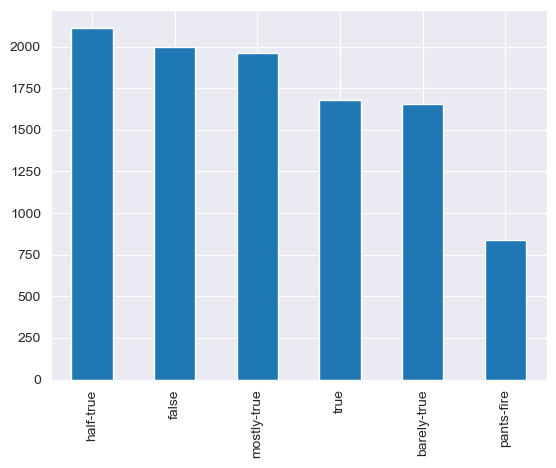

In [17]:
train_data['label'].value_counts().plot(kind='bar')

<AxesSubplot: >

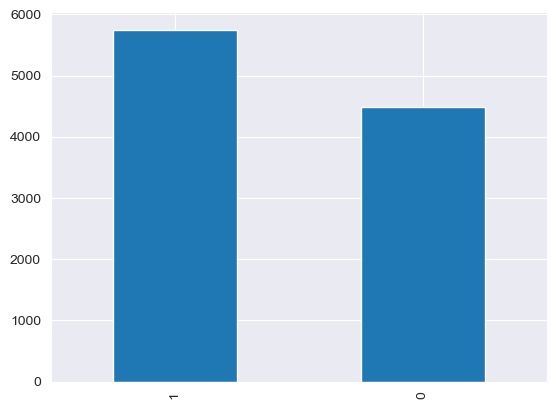

In [15]:
train_data['binaryoutput'] = train_data['output'].apply(lambda x: 1 if x > 2 else 0)
val_data['binaryoutput'] = val_data['output'].apply(lambda x: 1 if x > 2 else 0)
test_data['binaryoutput'] = test_data['output'].apply(lambda x: 1 if x > 2 else 0)

train_data['binaryoutput'].value_counts().plot(kind='bar')


<AxesSubplot: >

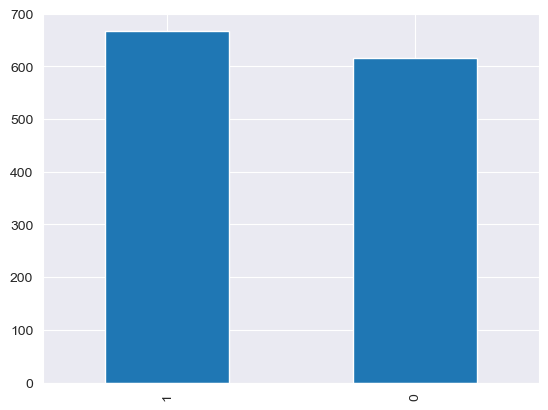

In [14]:
val_data['binaryoutput'].value_counts().plot(kind='bar')

<AxesSubplot: >

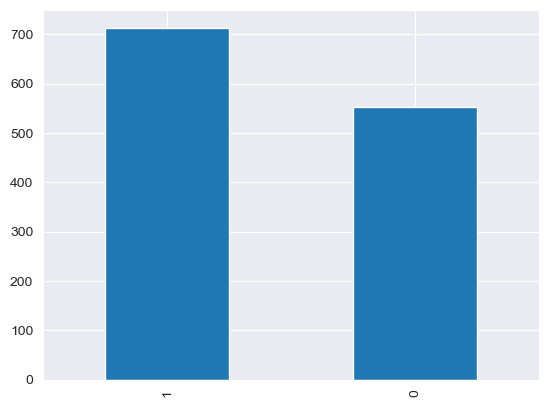

In [13]:
test_data['binaryoutput'].value_counts().plot(kind='bar')

In [4]:
# Load DEP_dict
with open('dep_dict.p', 'rb') as f:
    dep_dict_fine, dep_dict_custom = pickle.load(f)

In [5]:
# Load POS dict
with open('pos_dicts.p', 'rb') as f:
    pos_dict_custom, pos_dict_default, pos_dict_fine, pos_dict_fine_merged = pickle.load(f) #pos_dict_default is not used

In [6]:
train_data.columns

Index(['index', 'id', 'label', 'statement', 'subject', 'speaker', 'job-title',
       'party', 'barely-true-counts', 'false-counts', 'half-true-counts',
       'mostly-true-counts', 'pants-on-fire-counts', 'context', 'output',
       'preprocessed-subject', 'preprocessed-context', 'context-id-kmeans',
       'preprocessed-job-title', 'preprocessed-party', 'party-id-kmeans',
       'job-id-kmeans', 'subject-id-kmeans', 'pos-id-fine',
       'pos-id-fine-merged', 'pos-id-custom', 'dep-id-fine', 'dep-id-custom',
       'statement-customswr', 'statement-spacyswr', 'job-id-jaccard',
       'party-id-jaccard', 'context-id-jaccard', 'subject-id-jaccard',
       'word-id-custom', 'word-id-spacy'],
      dtype='object')

In [206]:
# train_data = train_data.rename(columns={'job-title-id-kmeans': 'job-id-kmeans'})
#
# val_data = val_data.rename(columns=
#                                {'preprocessed-context-clustered': 'context-id-kmeans',
#                                 'preprocessed-job-title-clustered': 'job-id-kmeans',
#                                 'preprocessed-party-clustered': 'party-id-kmeans',
#                                 'preprocessed-subject-clustered': 'subject-id-kmeans'
#                                 }
#                                )
#
# test_data = test_data.rename(columns=
#                                {'preprocessed-context-clustered': 'context-id-kmeans',
#                                 'preprocessed-job-title-clustered': 'job-id-kmeans',
#                                 'preprocessed-party-clustered': 'party-id-kmeans',
#                                 'preprocessed-subject-clustered': 'subject-id-kmeans'
#                                 }
#                                )

In [207]:
# train_data.columns

Index(['index', 'id', 'label', 'statement', 'subject', 'speaker', 'job-title',
       'party', 'barely-true-counts', 'false-counts', 'half-true-counts',
       'mostly-true-counts', 'pants-on-fire-counts', 'context', 'output',
       'preprocessed-subject', 'preprocessed-context', 'context-id-kmeans',
       'preprocessed-job-title', 'preprocessed-party', 'party-id-kmeans',
       'job-id-kmeans', 'subject-id-kmeans', 'pos-id-fine',
       'pos-id-fine-merged', 'pos-id-custom', 'dep-id-fine', 'dep-id-custom',
       'statement-customswr', 'statement-spacyswr', 'job-id-jaccard',
       'party-id-jaccard', 'context-id-jaccard', 'subject-id-jaccard',
       'word-id-custom', 'word-id-spacy'],
      dtype='object')

In [18]:
## OUTPUT
Y_train = train_data['output']
Y_train = keras.utils.to_categorical(Y_train, num_classes=6)

Y_val = val_data['output']
Y_val = keras.utils.to_categorical(Y_val, num_classes=6)

Y_test = test_data['output']
Y_test = keras.utils.to_categorical(Y_test, num_classes=6)

In [35]:
### BINARY OUTPUT
Y_train_binary = train_data['binaryoutput']
# Y_train_binary = keras.utils.to_categorical(Y_train_binary, num_classes=2)

Y_val_binary = val_data['binaryoutput']
# Y_val_binary = keras.utils.to_categorical(Y_val_binary, num_classes=2)

Y_test_binary = test_data['binaryoutput']
# Y_test_binary = keras.utils.to_categorical(Y_test_binary, num_classes=2)

In [209]:
# train_data.head()

,index,id,label,statement,subject,speaker,job-title,party,barely-true-counts,false-counts,...,dep-id-fine,dep-id-custom,statement-customswr,statement-spacyswr,job-id-jaccard,party-id-jaccard,context-id-jaccard,subject-id-jaccard,word-id-custom,word-id-spacy
0,0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,republican,0.0,1.0,...,"[8, 8, 4, 4, 3, 1, 8, 3, 8, 7, 2, 8, 8, 8]","[7, 5, 11, 11, 8, 6, 11, 8, 1, 4, 9, 2, 3, 1]",say annies list political group support third ...,say annies list political group support trimes...,2,0,13,2,"[3, 5440, 717, 493, 396, 54, 274, 4039, 155, 1...","[1, 5315, 633, 423, 332, 37, 3919, 120, 936]"
1,1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,democrat,0.0,0.0,...,"[8, 8, 8, 1, 8, 7, 8, 8, 1, 8, 8, 3, 1, 8, 8, ...","[11, 7, 5, 6, 2, 4, 3, 1, 6, 7, 11, 8, 6, 11, ...",when do decline coal start start when natural ...,decline coal start start natural gas take star...,6,1,0,5,"[37, 9, 804, 861, 308, 308, 37, 981, 254, 39, ...","[720, 773, 249, 249, 891, 204, 46, 249, 527, 1..."
2,2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,democrat,70.0,71.0,...,"[7, 1, 8, 8, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 2, ...","[4, 6, 7, 2, 4, 3, 1, 2, 11, 10, 11, 4, 11, 5,...",hillary clinton agree john mccain vote give ge...,hillary clinton agree john mccain vote george ...,2,1,3,5,"[104, 69, 734, 160, 201, 18, 89, 262, 137, 258...","[74, 49, 649, 125, 157, 12, 212, 103, 208, 274..."
3,3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,unknown,none,7.0,19.0,...,"[7, 7, 7, 1, 8, 8, 8, 8, 3, 7, 7, 2, 8]","[4, 4, 4, 6, 7, 11, 10, 11, 8, 4, 4, 9, 1]",health care reform legislation be likely manda...,health care reform legislation likely mandate ...,0,2,0,0,"[19, 22, 209, 252, 1, 592, 406, 361, 439, 176,...","[13, 16, 165, 202, 514, 342, 301, 372, 140, 2747]"
4,4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,unknown,democrat,15.0,9.0,...,"[8, 3, 1, 8, 8, 8, 8, 8, 8, 8, 8]","[5, 8, 6, 7, 2, 5, 3, 2, 11, 3, 1]",economic turnaround start end term,economic turnaround start end term,0,1,3,6,"[282, 3331, 308, 247, 248]","[224, 3208, 249, 198, 199]"


In [8]:
train_data['word-id-custom']

0        [3, 5440, 717, 493, 396, 54, 274, 4039, 155, 1...
1        [37, 9, 804, 861, 308, 308, 37, 981, 254, 39, ...
2        [104, 69, 734, 160, 201, 18, 89, 262, 137, 258...
3        [19, 22, 209, 252, 1, 592, 406, 361, 439, 176,...
4                               [282, 3331, 308, 247, 248]
                               ...                        
10235    [1, 161, 133, 5206, 314, 84, 86, 1, 408, 212, ...
10236       [157, 2, 52, 283, 213, 464, 1399, 653, 4, 389]
10237    [3, 2024, 154, 110, 1205, 3983, 124, 38, 2, 42...
10238       [1604, 28, 13, 2857, 3115, 4, 153, 1391, 1473]
10239    [216, 1429, 2087, 2, 5142, 826, 494, 327, 441,...
Name: word-id-custom, Length: 10240, dtype: object

### POS INPUT DATA

In [210]:
train_data['pos-id-fine']

0        [9, 16, 16, 12, 1, 10, 9, 1, 16, 10, 11, 16, 1...
1        [16, 5, 16, 10, 16, 10, 10, 16, 16, 5, 16, 1, ...
2        [12, 12, 9, 16, 12, 12, 16, 16, 6, 16, 4, 12, ...
3         [10, 10, 10, 10, 9, 1, 16, 4, 1, 10, 10, 11, 16]
4               [16, 1, 10, 5, 16, 16, 10, 16, 16, 10, 16]
                               ...                        
10235    [16, 8, 16, 2, 10, 16, 10, 11, 16, 12, 16, 16,...
10236    [16, 8, 13, 7, 16, 10, 16, 16, 16, 12, 16, 12,...
10237    [9, 16, 10, 16, 12, 12, 16, 9, 16, 12, 12, 16,...
10238        [16, 6, 16, 12, 1, 10, 16, 6, 10, 16, 12, 16]
10239    [16, 12, 16, 16, 16, 9, 16, 10, 13, 13, 6, 16,...
Name: pos-id-fine, Length: 10240, dtype: object

In [211]:
train_data['pos-id-custom']

0            [2, 15, 9, 9, 3, 1, 2, 3, 11, 1, 1, 5, 1, 11]
1        [8, 2, 15, 1, 5, 1, 1, 11, 6, 2, 8, 3, 1, 2, 5...
2        [9, 9, 2, 5, 9, 9, 11, 5, 2, 13, 2, 9, 9, 15, ...
3               [1, 1, 1, 1, 12, 3, 13, 2, 3, 1, 1, 1, 11]
4                     [15, 3, 1, 2, 5, 15, 1, 5, 6, 1, 11]
                               ...                        
10235    [6, 2, 15, 3, 1, 5, 1, 1, 5, 9, 8, 6, 2, 1, 5,...
10236    [9, 12, 4, 2, 15, 1, 5, 15, 15, 9, 11, 9, 1, 1...
10237    [2, 15, 1, 5, 9, 9, 6, 2, 5, 9, 9, 11, 9, 11, ...
10238              [5, 2, 15, 9, 3, 1, 16, 2, 1, 5, 9, 11]
10239    [15, 9, 5, 9, 9, 2, 15, 1, 4, 4, 2, 6, 1, 1, 5...
Name: pos-id-custom, Length: 10240, dtype: object

In [153]:
# Get the length of each list in a new column
train_data['sequence_length'] = train_data['pos-id-custom'].apply(len)

# Find the rows with sequence length greater than a specified threshold (e.g., 100)
long_sequences = train_data[train_data['sequence_length'] > 100]

# Display rows with long sequences
print("Rows with long sequences:")
print(long_sequences)

Rows with long sequences:
      index         id        label  \
1280   1280  1606.json  mostly-true   
2142   2142   638.json        false   
6119   6119  1993.json         true   
7550   7550  1720.json        false   

                                              statement  \
1280  Hospitals, doctors, MRIs, surgeries and so for...   
2142  The fact is that although we have had a presid...   
6119  Georgia has the most restrictive ballot access...   
7550  The vast majority of the money I got was from ...   

                      subject        speaker              job-title  \
1280  elections,ethics,states  charlie-crist                unknown   
2142                  unknown        unknown                unknown   
6119                    crime     dan-gelber                unknown   
7550  stimulus,transportation   bobby-jindal  Governor of Louisiana   

           party  barely-true-counts  false-counts  ...  \
1280    democrat                15.0           9.0  ...   
2142    

In [160]:
# import pandas as pd
#
# # Specify the row label and column label
# row_label = 1280
# column_label = 'word-id-customswr'
#
# # Access the value at the specified row and column
# cell_value = train_data.at[row_label, column_label]
#
# print("Value at row", row_label, "and column", column_label, ":", cell_value)


KeyError: 'word-id-customswr'

In [18]:
train_data['sequence-length'] = train_data['pos-id-fine'].apply(len)

# Find the maximum sequence length
max_sequence_length = train_data['sequence-length'].max()

long_sequences = train_data[train_data['sequence-length'] > 35]

# Display rows with long sequences
print("Rows with long sequences:")
print(long_sequences)

print("Max sequence length:", max_sequence_length)

Rows with long sequences:
       index          id        label  \
15        15  10683.json    half-true   
32        32   9727.json        false   
37        37   1038.json         true   
99        99   7128.json  mostly-true   
103      103  10624.json  mostly-true   
...      ...         ...          ...   
10208  10208   6339.json    half-true   
10226  10226   4614.json  mostly-true   
10233  10233   4388.json   pants-fire   
10234  10234   1592.json    half-true   
10239  10239   1155.json   pants-fire   

                                               statement  \
15     In this last election in November, ... 63 perc...   
32     What (the Obama administration is) going to co...   
37     The nuclear test conducted in our nation this ...   
99     A foreclosure tax that would take effect in 20...   
103    Says Secretary of State John Kerry, when he wa...   
...                                                  ...   
10208  Mike Dovillas big ideas like expanding the Ohi...   
1

In [11]:
# Find the maximum length of the sequences
# max_len = max(train_data['pos-id-custom'].apply(len).max()) # NOT APPLICABLE DUE TO ERROR IN ORIGINAL DATA

# avg length
train_data['sequence-length'].mean()

20.67294921875

# SET INPUT TENSORS

## POS, DEP Tensors

In [51]:
print(train_data['pos-id-custom'][40])

[2, 15, 9, 9, 9, 1, 2, 8, 15, 9, 1, 12, 12, 2, 2, 5, 3, 3, 1, 11]


In [48]:
pad_len = 35

# pad sequences for custom POS
X_train_pos_custom = pad_sequences(train_data['pos-id-custom'], maxlen=pad_len, padding='post', truncating='post')
X_val_pos_custom = pad_sequences(val_data['pos-id-custom'], maxlen=pad_len, padding='post', truncating='post')
X_test_pos_custom = pad_sequences(test_data['pos-id-custom'], maxlen=pad_len, padding='post', truncating='post')

# fine POS
X_train_pos_fine = pad_sequences(train_data['pos-id-fine'], maxlen=pad_len, padding='post', truncating='post')
X_val_pos_fine = pad_sequences(val_data['pos-id-fine'], maxlen=pad_len, padding='post', truncating='post')
X_test_pos_fine = pad_sequences(test_data['pos-id-fine'], maxlen=pad_len, padding='post', truncating='post')

# fine pos merged
X_train_pos_finemerge = pad_sequences(train_data['pos-id-fine-merged'], maxlen=pad_len, padding='post', truncating='post')
X_val_pos_finemerge = pad_sequences(val_data['pos-id-fine-merged'], maxlen=pad_len, padding='post', truncating='post')
X_test_pos_finemerge = pad_sequences(test_data['pos-id-fine-merged'], maxlen=pad_len, padding='post', truncating='post')

In [49]:
# custom dep
X_train_dep_custom = pad_sequences(train_data['dep-id-custom'], maxlen=pad_len, padding='post', truncating='post')
X_val_dep_custom = pad_sequences(val_data['dep-id-custom'], maxlen=pad_len, padding='post', truncating='post')
X_test_dep_custom = pad_sequences(test_data['dep-id-custom'], maxlen=pad_len, padding='post', truncating='post')

# fine dep
X_train_dep_fine = pad_sequences(train_data['dep-id-fine'], maxlen=pad_len, padding='post', truncating='post')
X_val_dep_fine = pad_sequences(val_data['dep-id-fine'], maxlen=pad_len, padding='post', truncating='post')
X_test_dep_fine = pad_sequences(test_data['dep-id-fine'], maxlen=pad_len, padding='post', truncating='post')

In [50]:
# custom word
X_train_custom = pad_sequences(train_data['word-id-custom'], maxlen=pad_len, padding='post', truncating='post')
X_val_custom = pad_sequences(val_data['word-id-custom'], maxlen=pad_len, padding='post', truncating='post')
X_test_custom = pad_sequences(test_data['word-id-custom'], maxlen=pad_len, padding='post', truncating='post')

# spacy word
X_train_spacy = pad_sequences(train_data['word-id-spacy'], maxlen=pad_len, padding='post', truncating='post')
X_val_spacy = pad_sequences(val_data['word-id-spacy'], maxlen=pad_len, padding='post', truncating='post')
X_test_spacy = pad_sequences(test_data['word-id-spacy'], maxlen=pad_len, padding='post', truncating='post')

In [24]:
len(X_train_spacy)

10240

In [44]:
len(pos_dict_custom)

15

## META Tensors

In [26]:
train_data['context-id-kmeans'].value_counts()

6     4286
7      980
9      737
5      705
2      667
4      666
1      654
3      322
10     314
0      284
8      222
11     213
12     190
Name: context-id-kmeans, dtype: int64

In [27]:
train_data['job-id-kmeans'].nunique()

8

In [26]:
# One-hot encode the metadata columns

# train sets
context_id_kmeans_encoded = to_categorical(train_data['context-id-kmeans'], num_classes=train_data['context-id-kmeans'].nunique())
subject_id_kmeans_encoded = to_categorical(train_data['subject-id-kmeans'], num_classes=train_data['subject-id-kmeans'].nunique())
job_id_kmeans_encoded = to_categorical(train_data['job-id-kmeans'], num_classes=train_data['job-id-kmeans'].nunique())
party_id_kmeans_encoded = to_categorical(train_data['party-id-kmeans'], num_classes=train_data['party-id-kmeans'].nunique())

context_id_jaccard_encoded = to_categorical(train_data['context-id-jaccard'], num_classes=train_data['context-id-jaccard'].nunique())
subject_id_jaccard_encoded = to_categorical(train_data['subject-id-jaccard'], num_classes=train_data['subject-id-jaccard'].nunique())
job_id_jaccard_encoded = to_categorical(train_data['job-id-jaccard'], num_classes=train_data['job-id-jaccard'].nunique())
party_id_jaccard_encoded = to_categorical(train_data['party-id-jaccard'], num_classes=train_data['party-id-jaccard'].nunique())

# validation sets
val_context_id_kmeans_encoded = to_categorical(val_data['context-id-kmeans'], num_classes=val_data['context-id-kmeans'].nunique())
val_subject_id_kmeans_encoded = to_categorical(val_data['subject-id-kmeans'], num_classes=val_data['subject-id-kmeans'].nunique())
val_job_id_kmeans_encoded = to_categorical(val_data['job-id-kmeans'], num_classes=val_data['job-id-kmeans'].nunique())
val_party_id_kmeans_encoded = to_categorical(val_data['party-id-kmeans'], num_classes=val_data['party-id-kmeans'].nunique())

val_context_id_jaccard_encoded = to_categorical(val_data['context-id-jaccard'], num_classes=val_data['context-id-jaccard'].nunique())
val_subject_id_jaccard_encoded = to_categorical(val_data['subject-id-jaccard'], num_classes=val_data['subject-id-jaccard'].nunique())
val_job_id_jaccard_encoded = to_categorical(val_data['job-id-jaccard'], num_classes=val_data['job-id-jaccard'].nunique())
val_party_id_jaccard_encoded = to_categorical(val_data['party-id-jaccard'], num_classes=val_data['party-id-jaccard'].nunique())

# test sets
test_context_id_kmeans_encoded = to_categorical(test_data['context-id-kmeans'], num_classes=test_data['context-id-kmeans'].nunique())
test_subject_id_kmeans_encoded = to_categorical(test_data['subject-id-kmeans'], num_classes=test_data['subject-id-kmeans'].nunique())
test_job_id_kmeans_encoded = to_categorical(test_data['job-id-kmeans'], num_classes=test_data['job-id-kmeans'].nunique())
test_party_id_kmeans_encoded = to_categorical(test_data['party-id-kmeans'], num_classes=test_data['party-id-kmeans'].nunique())

test_context_id_jaccard_encoded = to_categorical(test_data['context-id-jaccard'], num_classes=test_data['context-id-jaccard'].nunique())
test_subject_id_jaccard_encoded = to_categorical(test_data['subject-id-jaccard'], num_classes=test_data['subject-id-jaccard'].nunique())
test_job_id_jaccard_encoded = to_categorical(test_data['job-id-jaccard'], num_classes=test_data['job-id-jaccard'].nunique())
test_party_id_jaccard_encoded = to_categorical(test_data['party-id-jaccard'], num_classes=test_data['party-id-jaccard'].nunique())

In [27]:
# Concatenate the one-hot encoded categorical columns for each comparison case:
# K-means comparison
X_train_meta_kmeans = np.hstack((context_id_kmeans_encoded, subject_id_kmeans_encoded, job_id_kmeans_encoded, party_id_kmeans_encoded))
X_val_meta_kmeans = np.hstack((val_context_id_kmeans_encoded, val_subject_id_kmeans_encoded, val_job_id_kmeans_encoded, val_party_id_kmeans_encoded))
X_test_meta_kmeans = np.hstack((test_context_id_kmeans_encoded, test_subject_id_kmeans_encoded, test_job_id_kmeans_encoded, test_party_id_kmeans_encoded))

# Jaccard comparison
X_train_meta_jaccard = np.hstack((context_id_jaccard_encoded, subject_id_jaccard_encoded, job_id_jaccard_encoded, party_id_jaccard_encoded))
X_val_meta_jaccard = np.hstack((val_context_id_jaccard_encoded, val_subject_id_jaccard_encoded, val_job_id_jaccard_encoded, val_party_id_jaccard_encoded))
X_test_meta_jaccard = np.hstack((test_context_id_jaccard_encoded, test_subject_id_jaccard_encoded, test_job_id_jaccard_encoded, test_party_id_jaccard_encoded))

# TRAINING, TESTING

In [30]:
def create_dense_model(input_shape, num_classes, learning_rate):
    inputs = Input(shape=input_shape)
    dense = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(inputs)
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dropout(0.5)(dense)
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dropout(0.5)(dense)
    output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(dense)
    model = Model(inputs=inputs, outputs=output)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [31]:
# multiclass
def plot_matrix(predictions):
    """
    Makes predictions on test set + calculates performance metrics + plots confusion matrix
    :param predictions:
    :return: performance_metrics: A dictionary containing the performance metrics
    """
    # Convert the predictions to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    true_labels = np.argmax(Y_test, axis=1)

    # Calculate the accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f'Test set accuracy: {accuracy:.2f}')

    # Calculate the precision
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    print(f'Test set precision: {precision:.2f}')

    # Calculate the recall
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    print(f'Test set recall: {recall:.2f}')

    # Calculate the F1 score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    print(f'Test set F1 score: {f1:.2f}')

    # Calculate the confusion matrix
    conf_mat = confusion_matrix(true_labels, predicted_labels)

    print(conf_mat)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Return performance metrics as a dictionary
    performance_metrics = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}
    return performance_metrics


In [33]:
# binary classification
def plot_matrix_binary(predictions):
    """
    Makes predictions on test set + calculates performance metrics + plots confusion matrix
    :param predictions:
    :return: performance_metrics: A dictionary containing the performance metrics
    """
    # Convert the probabilities to class labels
    predicted_labels = (predictions > 0.5).astype(int)

    true_labels = Y_test_binary

    # Calculate the accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f'Test set accuracy: {accuracy:.2f}')

    # Calculate the precision
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    print(f'Test set precision: {precision:.2f}')

    # Calculate the recall
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    print(f'Test set recall: {recall:.2f}')

    # Calculate the F1 score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    print(f'Test set F1 score: {f1:.2f}')

    # Calculate the confusion matrix
    conf_mat = confusion_matrix(true_labels, predicted_labels)

    print(conf_mat)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Return performance metrics as a dictionary
    performance_metrics = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}
    return performance_metrics


## K-MEANS

In [36]:
# LR 0.0005 sbo T rbw T Adam PAD LEN 25

num_classes = 6
model_checkpoint_kmeans = ModelCheckpoint(filepath='best_model_kmeans.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
learning_rate = 0.0005
dense_model_kmeans = create_dense_model(X_train_meta_kmeans.shape[1], num_classes, learning_rate)
dense_model_kmeans.fit(X_train_meta_kmeans, Y_train, epochs=150, batch_size=128, validation_data=(X_val_meta_kmeans, Y_val), callbacks=[early_stopping, model_checkpoint_kmeans])

Epoch 1/150
80/80 [==============================] - 2s 9ms/step - loss: 2.5777 - accuracy: 0.1948 - val_loss: 2.2779 - val_accuracy: 0.1931
Epoch 2/150
80/80 [==============================] - 0s 5ms/step - loss: 2.1117 - accuracy: 0.2121 - val_loss: 2.0020 - val_accuracy: 0.2204
Epoch 3/150
80/80 [==============================] - 0s 5ms/step - loss: 1.9253 - accuracy: 0.2174 - val_loss: 1.8903 - val_accuracy: 0.2150
Epoch 4/150
80/80 [==============================] - 0s 5ms/step - loss: 1.8509 - accuracy: 0.2214 - val_loss: 1.8485 - val_accuracy: 0.2048
Epoch 5/150
80/80 [==============================] - 0s 5ms/step - loss: 1.8117 - accuracy: 0.2318 - val_loss: 1.8195 - val_accuracy: 0.2056
Epoch 6/150
80/80 [==============================] - 0s 5ms/step - loss: 1.7969 - accuracy: 0.2161 - val_loss: 1.8117 - val_accuracy: 0.2212
Epoch 7/150
80/80 [==============================] - 0s 5ms/step - loss: 1.7827 - accuracy: 0.2257 - val_loss: 1.8023 - val_accuracy: 0.2243
Epoch 8/150
8

40/40 [==============================] - 0s 1ms/step
Test set accuracy: 0.18
Test set precision: 0.10
Test set recall: 0.18
Test set F1 score: 0.12
[[  0  39   0  15  38   0]
 [  0 143   0  51  55   0]
 [  0 126   0  40  46   0]
 [  0 172   0  47  46   0]
 [  0 135   0  73  33   0]
 [  0 130   0  40  38   0]]


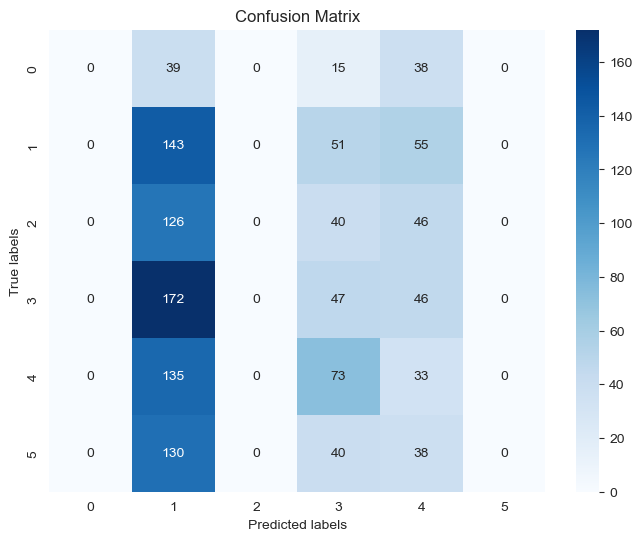

In [85]:
# Load the best model from the saved checkpoint
best_model_kmeans = load_model('best_model_kmeans.h5')

# Make predictions using the best model
dense_model_kmeans_predictions = best_model_kmeans.predict(X_test_meta_kmeans)

plot_matrix(dense_model_kmeans_predictions)

In [108]:
# from sklearn.metrics import accuracy_score
#
# # Assuming you have the true labels of the test set in a variable called `Y_test`
# true_labels = np.argmax(Y_test, axis=1)
#
# # Calculate the accuracy
# accuracy = accuracy_score(true_labels, predicted_labels)
# print(f'Test set accuracy: {accuracy:.2f}')


Test set accuracy: 0.20


In [106]:
num_classes = 6
# First training with learning_rate = 0.0005
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=10, restore_best_weights=True)
learning_rate = 0.0005
dense_model_kmeans = create_dense_model(X_train_meta_kmeans.shape[1], num_classes, learning_rate)
dense_model_kmeans.fit(X_train_meta_kmeans, Y_train, epochs=150, batch_size=128, validation_data=(X_val_meta_kmeans, Y_val), callbacks=[early_stopping, model_checkpoint_kmeans])

Epoch 1/150
80/80 [==============================] - 2s 8ms/step - loss: 2.6137 - accuracy: 0.1997 - val_loss: 2.3408 - val_accuracy: 0.1931
Epoch 2/150
80/80 [==============================] - 0s 5ms/step - loss: 2.1733 - accuracy: 0.2125 - val_loss: 2.0611 - val_accuracy: 0.2142
Epoch 3/150
80/80 [==============================] - 0s 5ms/step - loss: 1.9764 - accuracy: 0.2183 - val_loss: 1.9325 - val_accuracy: 0.2305
Epoch 4/150
80/80 [==============================] - 0s 5ms/step - loss: 1.8861 - accuracy: 0.2166 - val_loss: 1.8772 - val_accuracy: 0.2204
Epoch 5/150
80/80 [==============================] - 0s 5ms/step - loss: 1.8384 - accuracy: 0.2216 - val_loss: 1.8461 - val_accuracy: 0.2040
Epoch 6/150
80/80 [==============================] - 0s 5ms/step - loss: 1.8112 - accuracy: 0.2249 - val_loss: 1.8221 - val_accuracy: 0.2220
Epoch 7/150
80/80 [==============================] - 0s 5ms/step - loss: 1.7964 - accuracy: 0.2229 - val_loss: 1.8211 - val_accuracy: 0.2188
Epoch 8/150
8

In [116]:
evaluation = dense_model_kmeans.evaluate(X_test_meta_jaccard, Y_test)

# Load the best model from the saved checkpoint
best_model_kmeans = load_model('best_model_kmeans.h5')

# Make predictions using the best model
dense_model_kmeans_predictions = best_model_kmeans.predict(X_test_meta_kmeans)

plot_matrix(dense_model_kmeans_predictions)

40/40 [==============================] - 0s 2ms/step
[[  0  38   0  15  39   0]
 [  0 138   0  53  58   0]
 [  0 118   0  52  42   0]
 [  0 150   0  72  43   0]
 [  0 120   0  83  38   0]
 [  0 130   0  40  38   0]]


In [114]:
test_data['output'].value_counts()

3    265
1    249
4    241
2    212
5    208
0     92
Name: output, dtype: int64

In [93]:
print(Y_test)

[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]


In [90]:
from sklearn.metrics import confusion_matrix

# Get the predictions from the model
y_pred = np.argmax(dense_model_kmeans.predict(X_test_meta_kmeans), axis=-1)

# Convert the one-hot encoded labels back to their original format
y_true = np.argmax(Y_test, axis=-1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print(conf_matrix)

40/40 [==============================] - 0s 2ms/step
[[  0  23 194  48   0]
 [  0  17 184  40   0]
 [  0  45 190  65   0]
 [  0  31 181  37   0]
 [  0  23 144  45   0]]


In [77]:
# Second training with learning_rate = 0.001
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)
learning_rate = 0.001
dense_model_kmeans = create_dense_model(X_train_meta_kmeans.shape[1], num_classes, learning_rate) # Create a new model with fresh weights and updated learning rate
dense_model_kmeans.fit(X_train_meta_kmeans, Y_train, epochs=150, batch_size=128, validation_data=(X_val_meta_kmeans, Y_val), callbacks=[early_stopping, model_checkpoint_kmeans])

Epoch 1/150
80/80 [==============================] - 1s 8ms/step - loss: 2.2787 - accuracy: 0.2217 - val_loss: 1.8951 - val_accuracy: 0.2220
Epoch 2/150
80/80 [==============================] - 0s 5ms/step - loss: 1.7942 - accuracy: 0.2180 - val_loss: 1.7240 - val_accuracy: 0.2220
Epoch 3/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6952 - accuracy: 0.2342 - val_loss: 1.6763 - val_accuracy: 0.2220
Epoch 4/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6631 - accuracy: 0.2315 - val_loss: 1.6564 - val_accuracy: 0.2220
Epoch 5/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6479 - accuracy: 0.2284 - val_loss: 1.6441 - val_accuracy: 0.2220
Epoch 6/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6379 - accuracy: 0.2361 - val_loss: 1.6380 - val_accuracy: 0.2220
Epoch 7/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6324 - accuracy: 0.2342 - val_loss: 1.6357 - val_accuracy: 0.2220
Epoch 8/150
8

In [123]:
train_data['pos-id-fine']

0        [9, 16, 16, 12, 1, 10, 9, 1, 16, 10, 11, 16, 1...
1        [16, 5, 16, 10, 16, 10, 10, 16, 16, 5, 16, 1, ...
2        [12, 12, 9, 16, 12, 12, 16, 16, 6, 16, 4, 12, ...
3         [10, 10, 10, 10, 9, 1, 16, 4, 1, 10, 10, 11, 16]
4               [16, 1, 10, 5, 16, 16, 10, 16, 16, 10, 16]
                               ...                        
10235    [16, 8, 16, 2, 10, 16, 10, 11, 16, 12, 16, 16,...
10236    [16, 8, 13, 7, 16, 10, 16, 16, 16, 12, 16, 12,...
10237    [9, 16, 10, 16, 12, 12, 16, 9, 16, 12, 12, 16,...
10238        [16, 6, 16, 12, 1, 10, 16, 6, 10, 16, 12, 16]
10239    [16, 12, 16, 16, 16, 9, 16, 10, 13, 13, 6, 16,...
Name: pos-id-fine, Length: 10240, dtype: object

## JACCARD

In [281]:
# Testing restore best weights false
model_checkpoint_jaccard = ModelCheckpoint(filepath='best_model_jaccard.h5', monitor='val_categorical_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=10, restore_best_weights=False)

learning_rate = 0.0005

dense_model_jaccard = create_dense_model(X_train_meta_jaccard.shape[1], num_classes, learning_rate)
dense_model_jaccard.fit(X_train_meta_jaccard, Y_train, epochs=150, batch_size=128, validation_data=(X_val_meta_jaccard, Y_val), callbacks=[early_stopping, model_checkpoint_jaccard])

Epoch 1/150
80/80 [==============================] - 1s 9ms/step - loss: 2.5990 - accuracy: 0.1981 - val_loss: 2.3170 - val_accuracy: 0.1931
Epoch 2/150
80/80 [==============================] - 0s 5ms/step - loss: 2.1586 - accuracy: 0.2067 - val_loss: 2.0302 - val_accuracy: 0.1978
Epoch 3/150
80/80 [==============================] - 0s 5ms/step - loss: 1.9581 - accuracy: 0.2126 - val_loss: 1.9019 - val_accuracy: 0.2033
Epoch 4/150
80/80 [==============================] - 0s 5ms/step - loss: 1.8691 - accuracy: 0.2156 - val_loss: 1.8434 - val_accuracy: 0.2266
Epoch 5/150
80/80 [==============================] - 0s 5ms/step - loss: 1.8269 - accuracy: 0.2130 - val_loss: 1.8109 - val_accuracy: 0.2352
Epoch 6/150
80/80 [==============================] - 0s 5ms/step - loss: 1.8033 - accuracy: 0.2256 - val_loss: 1.7941 - val_accuracy: 0.2235
Epoch 7/150
80/80 [==============================] - 0s 5ms/step - loss: 1.7914 - accuracy: 0.2238 - val_loss: 1.7840 - val_accuracy: 0.2368
Epoch 8/150
8

40/40 [==============================] - 0s 1ms/step
Test set accuracy: 0.23
Test set precision: 0.14
Test set recall: 0.23
Test set F1 score: 0.17
[[  0  65   0  20   7   0]
 [  0 140   0  54  55   0]
 [  0 114   0  54  44   0]
 [  0 114   0  64  87   0]
 [  0  90   0  58  93   0]
 [  0  81   0  60  67   0]]


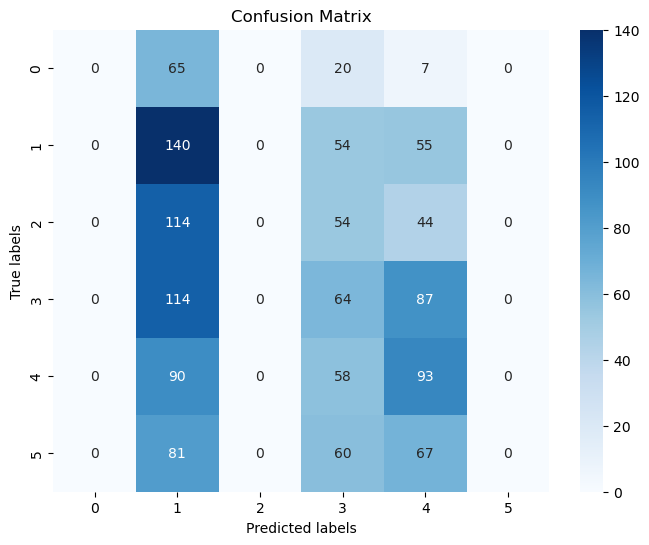

In [283]:
# evaluate dense_model_jaccard
evaluation = dense_model_jaccard.evaluate(X_test_meta_jaccard, Y_test)

# Load the best model from the saved checkpoint
best_model_jaccard = load_model('best_model_jaccard.h5')

# Make predictions using the best model
dense_model_jaccard_predictions = best_model_jaccard.predict(X_test_meta_jaccard)

plot_matrix(dense_model_jaccard_predictions)

In [79]:
# First training with learning_rate = 0.0005
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=10, restore_best_weights=True)
learning_rate = 0.0005
dense_model_jaccard = create_dense_model(X_train_meta_jaccard.shape[1], num_classes, learning_rate)
dense_model_jaccard.fit(X_train_meta_jaccard, Y_train, epochs=150, batch_size=128, validation_data=(X_val_meta_jaccard, Y_val), callbacks=[early_stopping, model_checkpoint_jaccard])

Epoch 1/150
80/80 [==============================] - 2s 8ms/step - loss: 2.5618 - accuracy: 0.2093 - val_loss: 2.2627 - val_accuracy: 0.2220
Epoch 2/150
80/80 [==============================] - 0s 5ms/step - loss: 2.1135 - accuracy: 0.2168 - val_loss: 1.9631 - val_accuracy: 0.2188
Epoch 3/150
80/80 [==============================] - 0s 5ms/step - loss: 1.9002 - accuracy: 0.2261 - val_loss: 1.8179 - val_accuracy: 0.2212
Epoch 4/150
80/80 [==============================] - 0s 4ms/step - loss: 1.7927 - accuracy: 0.2247 - val_loss: 1.7491 - val_accuracy: 0.2220
Epoch 5/150
80/80 [==============================] - 0s 4ms/step - loss: 1.7390 - accuracy: 0.2348 - val_loss: 1.7118 - val_accuracy: 0.2220
Epoch 6/150
80/80 [==============================] - 0s 4ms/step - loss: 1.7032 - accuracy: 0.2336 - val_loss: 1.6862 - val_accuracy: 0.2235
Epoch 7/150
80/80 [==============================] - 0s 4ms/step - loss: 1.6833 - accuracy: 0.2363 - val_loss: 1.6700 - val_accuracy: 0.2368
Epoch 8/150
8

In [120]:
# Second training with learning_rate = 0.001
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
learning_rate = 0.001
dense_model_jaccard = create_dense_model(X_train_meta_jaccard.shape[1], num_classes, learning_rate) # Create a new model with fresh weights and updated learning rate
dense_model_jaccard.fit(X_train_meta_jaccard, Y_train, epochs=150, batch_size=128, validation_data=(X_val_meta_jaccard, Y_val), callbacks=[early_stopping, model_checkpoint_jaccard])

Epoch 1/50
80/80 [==============================] - 2s 9ms/step - loss: 2.3710 - accuracy: 0.1940 - val_loss: 2.0040 - val_accuracy: 0.2181
Epoch 2/50
80/80 [==============================] - 0s 5ms/step - loss: 1.8989 - accuracy: 0.2107 - val_loss: 1.8313 - val_accuracy: 0.2336
Epoch 3/50
80/80 [==============================] - 0s 5ms/step - loss: 1.8089 - accuracy: 0.2197 - val_loss: 1.7951 - val_accuracy: 0.2188
Epoch 4/50
80/80 [==============================] - 0s 5ms/step - loss: 1.7837 - accuracy: 0.2198 - val_loss: 1.7764 - val_accuracy: 0.2305
Epoch 5/50
80/80 [==============================] - 0s 5ms/step - loss: 1.7710 - accuracy: 0.2173 - val_loss: 1.7681 - val_accuracy: 0.2321
Epoch 6/50
80/80 [==============================] - 0s 5ms/step - loss: 1.7649 - accuracy: 0.2149 - val_loss: 1.7644 - val_accuracy: 0.2383
Epoch 7/50
80/80 [==============================] - 0s 5ms/step - loss: 1.7607 - accuracy: 0.2296 - val_loss: 1.7606 - val_accuracy: 0.2305
Epoch 8/50
80/80 [==

40/40 [==============================] - 0s 2ms/step
Test set accuracy: 0.23
Test set precision: 0.13
Test set recall: 0.23
Test set F1 score: 0.16


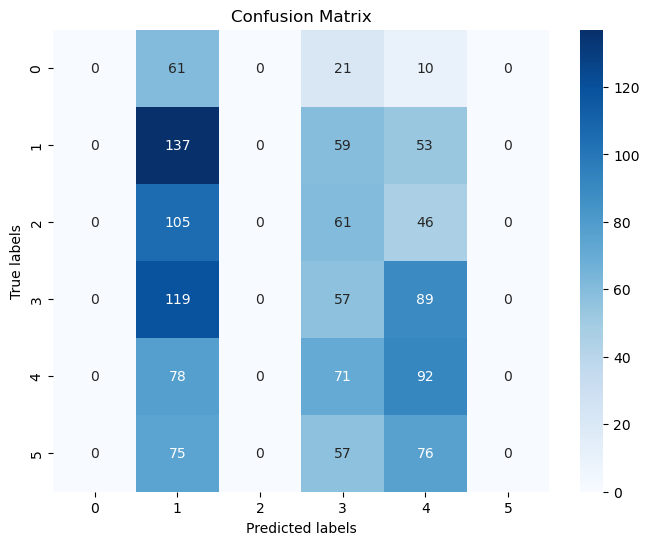

In [121]:
evaluation = dense_model_jaccard.evaluate(X_test_meta_jaccard, Y_test)

# Load the best model from the saved checkpoint
best_model_jaccard = load_model('best_model_jaccard.h5')

# Make predictions using the best model
dense_model_jaccard_predictions = best_model_jaccard.predict(X_test_meta_jaccard)

plot_matrix(dense_model_jaccard_predictions)

# MULTI INPUT DENSE MODEL

In [86]:
# vocabulary_dict_custom = pickle.load(open('vocabulary_statement_custom.p', 'rb'))
# vocabulary_dict_spacy = pickle.load(open('vocabulary_statement_spacy.p', 'rb'))
# # vocab_length = len(vocabulary_dict_custom)
# print("Length of the vocabulary dictionaries:", len(vocabulary_dict_custom), len(vocabulary_dict_spacy))

Length of the vocabulary dictionaries: 9606 9495


In [55]:
# Multi input dense ORGINAL IMPORTANT
def create_multi_input_dense_model(input_shape_meta, vocab_size_pos, vocab_size_dep, num_classes, learning_rate, input_seq_length):
    # Define separate input layers for each feature type
    input_meta = Input(shape=input_shape_meta, name="meta_input")
    input_pos = Input(shape=(input_seq_length,), name="pos_input")
    input_dep = Input(shape=(input_seq_length,), name="dep_input")

    # Define initial processing layers for each feature type
    meta_dense = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(input_meta)
    pos_embedding = Embedding(vocab_size_pos, 16)(input_pos)
    pos_flat = Flatten()(pos_embedding)
    dep_embedding = Embedding(vocab_size_dep, 16)(input_dep)
    dep_flat = Flatten()(dep_embedding)

    # Concatenate the outputs of the initial processing layers
    concat = Concatenate()([meta_dense, pos_flat, dep_flat])

    # Add additional Dense layers after concatenation
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(concat)
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dropout(0.5)(dense)
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dropout(0.5)(dense)

    # Add the final output layer
    output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(dense)

    # Create and compile the model
    model = Model(inputs=[input_meta, input_pos, input_dep], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

In [238]:
# print length pos_dict fine
print("POS vocabulary size:", len(pos_dict_fine))

POS vocabulary size: 16


In [237]:
# print max of pos_dict fine
print("POS vocabulary max value:", max(pos_dict_fine_merged.values()))

POS vocabulary max value: 5


In [ ]:
# num_classes = 6
# # First training with learning_rate = 0.0005
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# learning_rate = 0.0005
# # dense_model_kmeans = create_dense_model(X_train_meta_kmeans.shape[1], num_classes, learning_rate)
# # dense_model_kmeans.fit(X_train_meta_kmeans, Y_train, epochs=150, batch_size=128, validation_data=(X_val_meta_kmeans, Y_val), callbacks=[early_stopping, model_checkpoint_kmeans])

In [ ]:
# Create ModelCheckpoint callback
# model_checkpoint_jaccard_pfine_dfine = ModelCheckpoint(filepath='best_model_jaccard_pfine_dfine.h5', monitor='val_loss', save_best_only=True)
# model_checkpoint_kmeans = ModelCheckpoint(filepath='best_model_kmeans.h5', monitor='val_loss', save_best_only=True)

## JACCARD META, pos_fine, dep_fine

In [41]:
# JACCARD META, pos_fine, dep_fine
# INITIALISE
input_shape_meta = (X_train_meta_jaccard.shape[1],) # JACCARD META
vocab_size_pos_fine =  max(pos_dict_fine.values())+1 # FINE GRAINED POS
vocab_size_dep_fine = max(dep_dict_fine.values())+1 # FINE GRAINED DEP

model_checkpoint_jaccard_pfine_dfine = ModelCheckpoint(filepath='best_model_jaccard_pfine_dfine.h5', monitor='val_categorical_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=10, restore_best_weights=True)

num_classes = 6
learning_rate = 0.00025

# Create the JACCARD META, pos_fine, dep_fine model
dense_model_jaccard_pfine_dfine = create_multi_input_dense_model(input_shape_meta, vocab_size_pos_fine, vocab_size_dep_fine, num_classes, learning_rate, pad_len)

# TRAIN
dense_model_jaccard_pfine_dfine.fit([X_train_meta_jaccard, X_train_pos_fine, X_train_dep_fine], Y_train, epochs=50, batch_size=128, validation_data=([X_val_meta_jaccard, X_val_pos_fine, X_val_dep_fine], Y_val), callbacks=[early_stopping, model_checkpoint_jaccard_pfine_dfine])

Epoch 1/50
80/80 [==============================] - 3s 16ms/step - loss: 2.7745 - categorical_accuracy: 0.1915 - val_loss: 2.5197 - val_categorical_accuracy: 0.1931
Epoch 2/50
80/80 [==============================] - 1s 10ms/step - loss: 2.3585 - categorical_accuracy: 0.2005 - val_loss: 2.2170 - val_categorical_accuracy: 0.1931
Epoch 3/50
80/80 [==============================] - 1s 10ms/step - loss: 2.1302 - categorical_accuracy: 0.2012 - val_loss: 2.0501 - val_categorical_accuracy: 0.1978
Epoch 4/50
80/80 [==============================] - 1s 11ms/step - loss: 1.9993 - categorical_accuracy: 0.2049 - val_loss: 1.9490 - val_categorical_accuracy: 0.2196
Epoch 5/50
80/80 [==============================] - 1s 10ms/step - loss: 1.9191 - categorical_accuracy: 0.2164 - val_loss: 1.8927 - val_categorical_accuracy: 0.2375
Epoch 6/50
80/80 [==============================] - 1s 10ms/step - loss: 1.8677 - categorical_accuracy: 0.2263 - val_loss: 1.8446 - val_categorical_accuracy: 0.2625
Epoch 7/50

40/40 [==============================] - 1s 22ms/step
Test set accuracy: 0.26
Test set precision: 0.15
Test set recall: 0.26
Test set F1 score: 0.19
[[  0  65   0  12  15   0]
 [  0 147   0  50  52   0]
 [  0 117   0  34  61   0]
 [  0 119   0  63  83   0]
 [  0  71   0  55 115   0]
 [  0  75   0  34  99   0]]


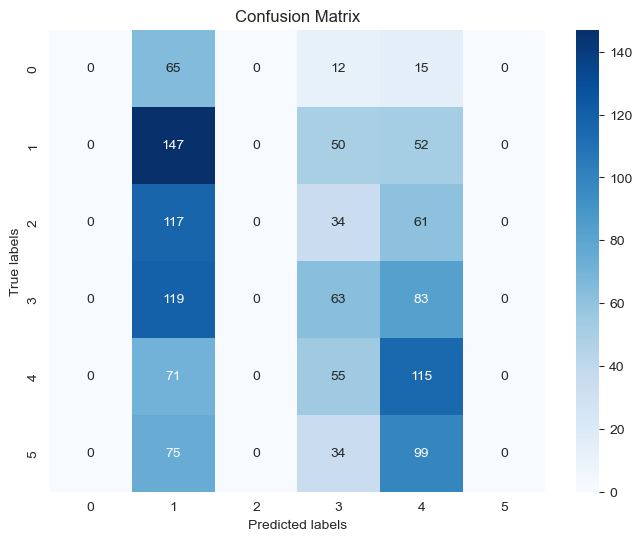

{'accuracy': 0.2565114443567482,
 'precision': 0.15323719432848557,
 'recall': 0.2565114443567482,
 'f1': 0.18560047764618737}

In [42]:

# Load the best model from the saved checkpoint
best_model_jaccard_pfine_dfine = load_model('best_model_jaccard_pfine_dfine.h5')
dense_model_jaccard_pfine_dfine_predictions = best_model_jaccard_pfine_dfine.predict([X_test_meta_jaccard, X_test_pos_fine, X_test_dep_fine])

plot_matrix(dense_model_jaccard_pfine_dfine_predictions)

## JACCARD META, pos_fine, dep_custom

In [37]:
# JACCARD META, pos_fine, dep_custom
# INITIALISE
input_shape_meta = (X_train_meta_jaccard.shape[1],) # JACCARD META
vocab_size_pos_fine =  max(pos_dict_fine.values())+1 # FINE GRAINED POS
vocab_size_dep_custom = max(dep_dict_custom.values())+1 # CUSTOM DEP

model_checkpoint_jaccard_pfine_dcustom = ModelCheckpoint(filepath='best_model_jaccard_pfine_dcustom.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

num_classes = 6
learning_rate = 0.00025
# max_len = 30

# Create the JACCARD META, pos_fine, dep_custom model
dense_model_jaccard_pfine_dcustom = create_multi_input_dense_model(input_shape_meta, vocab_size_pos_fine, vocab_size_dep_custom, num_classes, learning_rate, pad_len)

# TRAIN
dense_model_jaccard_pfine_dcustom.fit([X_train_meta_jaccard, X_train_pos_fine, X_train_dep_custom], Y_train, epochs=150, batch_size=128, validation_data=([X_val_meta_jaccard, X_val_pos_fine, X_val_dep_custom], Y_val), callbacks=[early_stopping, model_checkpoint_jaccard_pfine_dcustom])

Epoch 1/150
80/80 [==============================] - 2s 13ms/step - loss: 2.7885 - accuracy: 0.2012 - val_loss: 2.5525 - val_accuracy: 0.2048
Epoch 2/150
80/80 [==============================] - 1s 9ms/step - loss: 2.3997 - accuracy: 0.1989 - val_loss: 2.2620 - val_accuracy: 0.2025
Epoch 3/150
80/80 [==============================] - 1s 9ms/step - loss: 2.1733 - accuracy: 0.2148 - val_loss: 2.0877 - val_accuracy: 0.2251
Epoch 4/150
80/80 [==============================] - 1s 10ms/step - loss: 2.0394 - accuracy: 0.2197 - val_loss: 1.9896 - val_accuracy: 0.2375
Epoch 5/150
80/80 [==============================] - 1s 10ms/step - loss: 1.9560 - accuracy: 0.2226 - val_loss: 1.9163 - val_accuracy: 0.2430
Epoch 6/150
80/80 [==============================] - 1s 7ms/step - loss: 1.9001 - accuracy: 0.2251 - val_loss: 1.8733 - val_accuracy: 0.2570
Epoch 7/150
80/80 [==============================] - 1s 7ms/step - loss: 1.8593 - accuracy: 0.2311 - val_loss: 1.8464 - val_accuracy: 0.2578
Epoch 8/15

40/40 [==============================] - 0s 9ms/step
Test set accuracy: 0.25
Test set precision: 0.15
Test set recall: 0.25
Test set F1 score: 0.19
[[  0  60   0  14  18   0]
 [  0 130   0  55  64   0]
 [  0  99   0  56  57   0]
 [  0 102   0  76  87   0]
 [  0  66   0  58 117   0]
 [  0  69   0  40  99   0]]


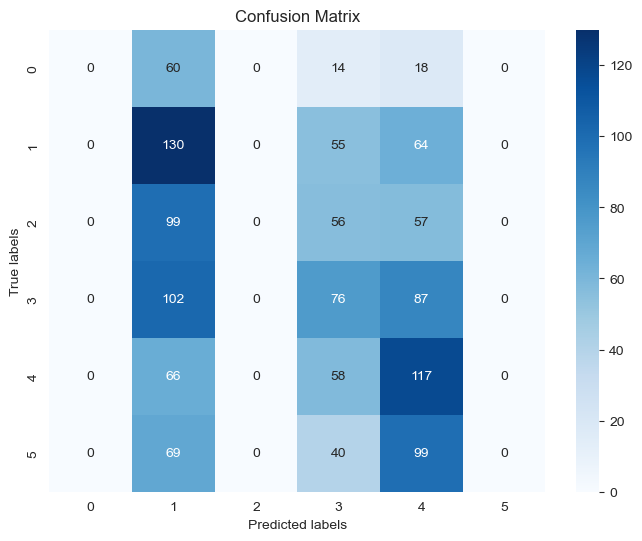

In [96]:
# CONFUSION MATRIX AND PREDICTIONS
evaluation = dense_model_jaccard_pfine_dcustom.evaluate([X_test_meta_jaccard, X_test_pos_fine, X_test_dep_custom], Y_test)

# Load the best model from the saved checkpoint
best_model_jaccard_pfine_dcustom = load_model('best_model_jaccard_pfine_dcustom.h5')

# Make predictions using the best model
dense_model_jaccard_pfine_dcustom_predictions = best_model_jaccard_pfine_dcustom.predict([X_test_meta_jaccard, X_test_pos_fine, X_test_dep_custom])

plot_matrix(dense_model_jaccard_pfine_dcustom_predictions)

## JACCARD META, pos_merge, dep_fine

In [57]:
# JACCARD META, pos_merge, dep_fine
# INITIALISE
input_shape_meta = (X_train_meta_jaccard.shape[1],) # JACCARD META
vocab_size_pos_merge =  max(pos_dict_fine_merged.values())+1 # MERGED POS
vocab_size_dep_fine = max(dep_dict_fine.values())+1 # FINE GRAINED DEP

model_checkpoint_jaccard_pmerge_dfine = ModelCheckpoint(filepath='best_model_jaccard_pmerge_dfine.h5', monitor='val_categorical_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=10, restore_best_weights=True)

num_classes = 6
learning_rate = 0.00025
# max_len = 30

# Create and train the JACCARD META, pos_merge, dep_fine model
dense_model_jaccard_pmerge_dfine = create_multi_input_dense_model(input_shape_meta, vocab_size_pos_merge, vocab_size_dep_fine, num_classes, learning_rate, pad_len)

# train
dense_model_jaccard_pmerge_dfine.fit([X_train_meta_jaccard, X_train_pos_finemerge, X_train_dep_fine], Y_train, epochs=150, batch_size=128, validation_data=([X_val_meta_jaccard, X_val_pos_finemerge, X_val_dep_fine], Y_val), callbacks=[early_stopping, model_checkpoint_jaccard_pmerge_dfine])

Epoch 1/150
80/80 [==============================] - 3s 18ms/step - loss: 2.7858 - categorical_accuracy: 0.1991 - val_loss: 2.5462 - val_categorical_accuracy: 0.1931
Epoch 2/150
80/80 [==============================] - 1s 8ms/step - loss: 2.3910 - categorical_accuracy: 0.1990 - val_loss: 2.2526 - val_categorical_accuracy: 0.1931
Epoch 3/150
80/80 [==============================] - 1s 7ms/step - loss: 2.1635 - categorical_accuracy: 0.2003 - val_loss: 2.0827 - val_categorical_accuracy: 0.1963
Epoch 4/150
80/80 [==============================] - 1s 11ms/step - loss: 2.0309 - categorical_accuracy: 0.2059 - val_loss: 1.9793 - val_categorical_accuracy: 0.1931
Epoch 5/150
80/80 [==============================] - 1s 11ms/step - loss: 1.9488 - categorical_accuracy: 0.2112 - val_loss: 1.9156 - val_categorical_accuracy: 0.2344
Epoch 6/150
80/80 [==============================] - 1s 6ms/step - loss: 1.8946 - categorical_accuracy: 0.2153 - val_loss: 1.8741 - val_categorical_accuracy: 0.2282
Epoch 7

40/40 [==============================] - 2s 31ms/step
Test set accuracy: 0.24
Test set precision: 0.14
Test set recall: 0.24
Test set F1 score: 0.18
[[  0  50   0  26  16   0]
 [  0 115   0  76  58   0]
 [  0  80   0  71  61   0]
 [  0  90   0  75 100   0]
 [  0  49   0  72 120   0]
 [  0  52   0  60  96   0]]


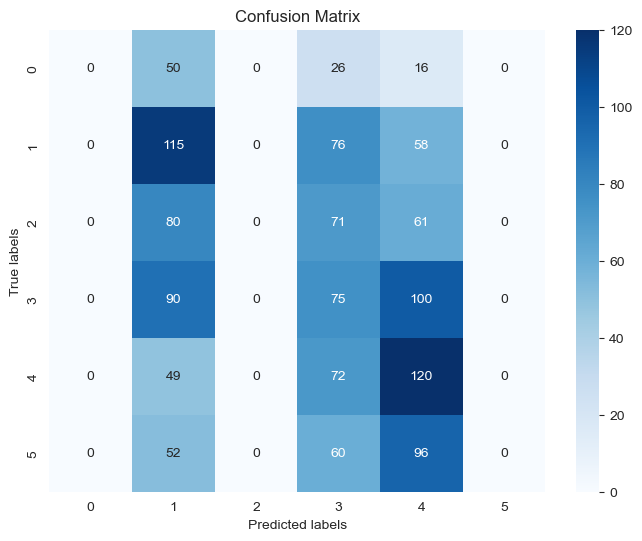

{'accuracy': 0.244672454617206,
 'precision': 0.14372802336065266,
 'recall': 0.244672454617206,
 'f1': 0.18059791745990866}

In [58]:
# evaluate dense_model_jaccard_pmerge_dfine
evaluation = dense_model_jaccard_pmerge_dfine.evaluate([X_test_meta_jaccard, X_test_pos_finemerge, X_test_dep_fine], Y_test)

# Load the best model from the saved checkpoint
best_model_jaccard_pmerge_dfine = load_model('best_model_jaccard_pmerge_dfine.h5')

# Make predictions using the best model
dense_model_jaccard_pmerge_dfine_predictions = best_model_jaccard_pmerge_dfine.predict([X_test_meta_jaccard, X_test_pos_finemerge, X_test_dep_fine])

plot_matrix(dense_model_jaccard_pmerge_dfine_predictions)

## JACCARD META, pos_merge, dep_custom

In [279]:
# JACCARD META, pos_merge, dep_custom
# INITIALISE
input_shape_meta = (X_train_meta_jaccard.shape[1],) # JACCARD META
vocab_size_pos_merge =  max(pos_dict_fine_merged.values())+1 # MERGED POS
vocab_size_dep_custom = max(dep_dict_custom.values())+1 # CUSTOM DEP

model_checkpoint_jaccard_pmerge_dcustom = ModelCheckpoint(filepath='best_model_jaccard_pmerge_dcustom.h5', monitor='val_categorical_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=10, restore_best_weights=False)

num_classes = 6
learning_rate = 0.0005
# max_len = 30

# Create and train the JACCARD META, pos_merge, dep_custom model
dense_model_jaccard_pmerge_dcustom = create_multi_input_dense_model(input_shape_meta, vocab_size_pos_merge, vocab_size_dep_custom, num_classes, learning_rate, pad_len)
dense_model_jaccard_pmerge_dcustom.fit([X_train_meta_jaccard, X_train_pos_finemerge, X_train_dep_custom], Y_train, epochs=150, batch_size=128, validation_data=([X_val_meta_jaccard, X_val_pos_finemerge, X_val_dep_custom], Y_val), callbacks=[early_stopping, model_checkpoint_jaccard_pmerge_dcustom])

Epoch 1/150
80/80 [==============================] - 3s 18ms/step - loss: 2.6308 - accuracy: 0.1964 - val_loss: 2.3021 - val_accuracy: 0.1931
Epoch 2/150
80/80 [==============================] - 1s 11ms/step - loss: 2.1409 - accuracy: 0.1977 - val_loss: 2.0147 - val_accuracy: 0.2157
Epoch 3/150
80/80 [==============================] - 1s 11ms/step - loss: 1.9512 - accuracy: 0.2060 - val_loss: 1.8994 - val_accuracy: 0.2259
Epoch 4/150
80/80 [==============================] - 1s 12ms/step - loss: 1.8717 - accuracy: 0.2102 - val_loss: 1.8464 - val_accuracy: 0.2321
Epoch 5/150
80/80 [==============================] - 1s 9ms/step - loss: 1.8254 - accuracy: 0.2201 - val_loss: 1.8143 - val_accuracy: 0.2469
Epoch 6/150
80/80 [==============================] - 1s 11ms/step - loss: 1.8024 - accuracy: 0.2298 - val_loss: 1.7946 - val_accuracy: 0.2492
Epoch 7/150
80/80 [==============================] - 1s 10ms/step - loss: 1.7874 - accuracy: 0.2342 - val_loss: 1.7804 - val_accuracy: 0.2664
Epoch 8

40/40 [==============================] - 1s 13ms/step
Test set accuracy: 0.25
Test set precision: 0.15
Test set recall: 0.25
Test set F1 score: 0.18
[[  0  64   0  20   8   0]
 [  0 151   0  50  48   0]
 [  0 123   0  46  43   0]
 [  0 126   0  62  77   0]
 [  0  82   0  59 100   0]
 [  0  78   0  52  78   0]]


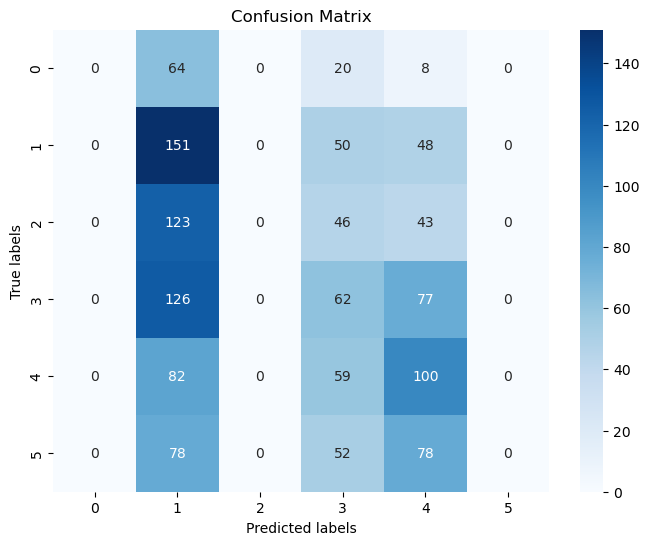

In [280]:
# evaluate dense_model_jaccard_pmerge_dcustom and make prediction and plot confusion matrix
evaluation = dense_model_jaccard_pmerge_dcustom.evaluate([X_test_meta_jaccard, X_test_pos_finemerge, X_test_dep_custom], Y_test)
best_model_jaccard_pmerge_dcustom = load_model('best_model_jaccard_pmerge_dcustom.h5')
dense_model_jaccard_pmerge_dcustom_predictions = best_model_jaccard_pmerge_dcustom.predict([X_test_meta_jaccard, X_test_pos_finemerge, X_test_dep_custom])
plot_matrix(dense_model_jaccard_pmerge_dcustom_predictions)

## JACCARD META, pos_default, dep_fine

In [53]:
print(dep_dict_fine)


{'nsubj': 1, 'dobj': 2, 'amod': 3, 'nmod': 4, 'acl': 5, 'conj': 6, 'compound': 7, 'OTHER': 8}


In [ ]:
# JACCARD META, pos_default, dep_fine
# INITIALISE
input_shape_meta = (X_train_meta_jaccard.shape[1],) # JACCARD META
vocab_size_pos_custom =  max(pos_dict_custom.values())+2 # CUSTOM POS
vocab_size_dep_fine = max(dep_dict_fine.values())+1 # FINE GRAINED DEP

model_checkpoint_jaccard_pdefault_dfine = ModelCheckpoint(filepath='best_model_jaccard_pdefault_dfine.h5', monitor='val_categorical_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=10, restore_best_weights=False)

num_classes = 6
learning_rate = 0.00025
# max_len = 30

# Create and train the JACCARD META, pos_custom, dep_fine model
dense_model_jaccard_pcustom_dfine = create_multi_input_dense_model(input_shape_meta, vocab_size_pos_custom, vocab_size_dep_fine, num_classes, learning_rate, pad_len)
dense_model_jaccard_pcustom_dfine.fit([X_train_meta_jaccard, X_train_pos_custom, X_train_dep_fine], Y_train, epochs=150, batch_size=128, validation_data=([X_val_meta_jaccard, X_val_pos_custom, X_val_dep_fine], Y_val), callbacks=[early_stopping, model_checkpoint_jaccard_pdefault_dfine])

40/40 [==============================] - 0s 6ms/step
Test set accuracy: 0.26
Test set precision: 0.15
Test set recall: 0.26
Test set F1 score: 0.18
[[  0  69   0   9  14   0]
 [  0 151   0  46  52   0]
 [  0 124   0  39  49   0]
 [  0 115   0  61  89   0]
 [  0  74   0  55 112   0]
 [  0  77   0  44  87   0]]


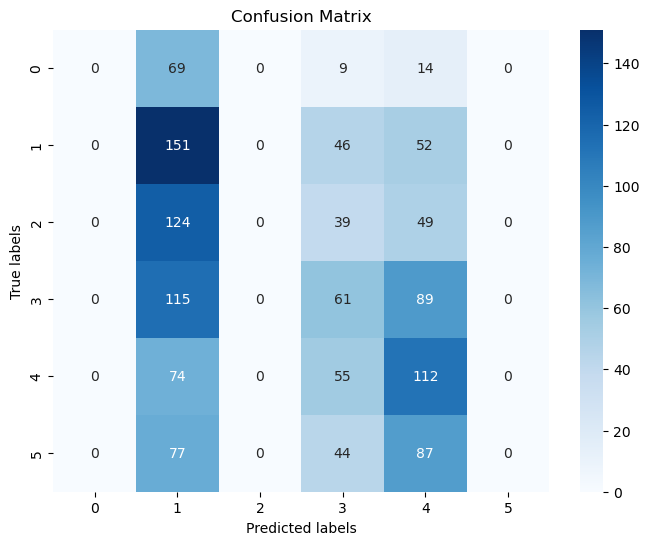

In [289]:
# evaluate dense_model_jaccard_pcustom_dfine and make prediction and plot confusion matrix
evaluation = dense_model_jaccard_pcustom_dfine.evaluate([X_test_meta_jaccard, X_test_pos_custom, X_test_dep_fine], Y_test)
best_model_jaccard_pcustom_dfine = load_model('best_model_jaccard_pdefault_dfine.h5')

dense_model_jaccard_pcustom_dfine_predictions = best_model_jaccard_pcustom_dfine.predict([X_test_meta_jaccard, X_test_pos_custom, X_test_dep_fine])
plot_matrix(dense_model_jaccard_pcustom_dfine_predictions)

# BILSTM-GRU

## Multiclass BILSTM-GRU

In [69]:
def create_bilstm_gru_model(vocab_size, embedding_dim, embedding_matrix, input_length, learning_rate):
    inputs = Input(shape=(input_length,))
    embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=input_length, trainable=False)(inputs)
    bilstm = Bidirectional(LSTM(50, return_sequences=True))(embedding)
    bigru, forward_h, backward_h = Bidirectional(GRU(50, return_sequences=True, return_state=True))(embedding)
    max_pool_lstm = GlobalMaxPooling1D()(bilstm)
    max_pool_gru = GlobalMaxPooling1D()(bigru)
    avg_pool_lstm = GlobalAveragePooling1D()(bilstm)
    avg_pool_gru = GlobalAveragePooling1D()(bigru)
    state_h = Concatenate()([forward_h, backward_h])
    concat = Concatenate()([max_pool_lstm, max_pool_gru, avg_pool_lstm, avg_pool_gru, state_h])
    output = Dense(6, activation='sigmoid')(concat)
    model = Model(inputs=inputs, outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

### Spacy multiclass

In [106]:
# BILSTM_GRU_SPACY WITHOUT CLASS WEIGHT RESTORE BEST WEIGHTS TRUE
vocab_size = len(vocabulary_dict_spacy) + 1
embedding_dim = 300
embedding_matrix = embedding_matrix_spacy_300d
# pad_len = 35
learning_rate = 0.00025

bilstm_gru_model_spacy = create_bilstm_gru_model(vocab_size, embedding_dim, embedding_matrix, pad_len, learning_rate)

# model checkpoint
model_checkpoint_bilstm_gru_spacy = ModelCheckpoint(filepath='best_model_bilstm_gru_spacy.h5', monitor='val_categorical_accuracy', save_best_only=True)
# early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=3, restore_best_weights=True)

bilstm_gru_model_spacy.fit(X_train_spacy, Y_train, epochs=15, batch_size=64, validation_data=(X_val_spacy, Y_val), callbacks=[early_stopping, model_checkpoint_bilstm_gru_spacy])

Epoch 1/15
160/160 [==============================] - 20s 76ms/step - loss: 1.7571 - categorical_accuracy: 0.2131 - val_loss: 1.7373 - val_categorical_accuracy: 0.2298
Epoch 2/15
160/160 [==============================] - 9s 59ms/step - loss: 1.7115 - categorical_accuracy: 0.2590 - val_loss: 1.7232 - val_categorical_accuracy: 0.2461
Epoch 3/15
160/160 [==============================] - 9s 59ms/step - loss: 1.6854 - categorical_accuracy: 0.2896 - val_loss: 1.7097 - val_categorical_accuracy: 0.2562
Epoch 4/15
160/160 [==============================] - 9s 58ms/step - loss: 1.6622 - categorical_accuracy: 0.3127 - val_loss: 1.7160 - val_categorical_accuracy: 0.2422
Epoch 5/15
160/160 [==============================] - 10s 61ms/step - loss: 1.6373 - categorical_accuracy: 0.3328 - val_loss: 1.7135 - val_categorical_accuracy: 0.2469
Epoch 6/15
160/160 [==============================] - 10s 62ms/step - loss: 1.6145 - categorical_accuracy: 0.3469 - val_loss: 1.7027 - val_categorical_accuracy: 0.

40/40 [==============================] - 2s 18ms/step
Test set accuracy: 0.26
Test set precision: 0.27
Test set recall: 0.26
Test set F1 score: 0.25
[[15 30 10 10 20  7]
 [12 91 21 43 57 25]
 [16 54 30 44 57 11]
 [ 7 59 28 61 89 21]
 [ 8 47 11 50 96 29]
 [13 39  6 36 75 39]]


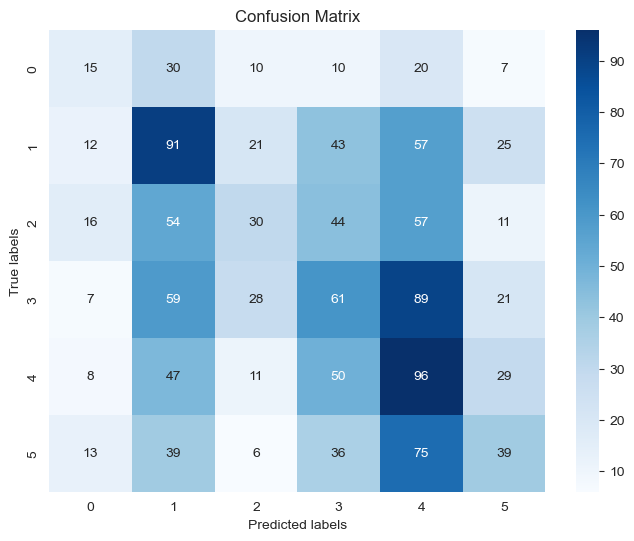

{'accuracy': 0.26203630623520124,
 'precision': 0.26572324574238076,
 'recall': 0.26203630623520124,
 'f1': 0.25310271851467425}

In [107]:
# evaluate bilstm_gru_model_spacy and make prediction and plot confusion matrix
evaluation = bilstm_gru_model_spacy.evaluate(X_test_spacy, Y_test)
best_model_bilstm_gru_spacy = load_model('best_model_bilstm_gru_spacy.h5')

bilstm_gru_model_spacy_predictions = best_model_bilstm_gru_spacy.predict(X_test_spacy)
plot_matrix(bilstm_gru_model_spacy_predictions)

### Custom multiclass

In [108]:
# BILSTM_GRU_CUSTOM WITHOUT CLASS WEIGHT RESTORE BEST WEIGHTS TRUE
vocab_size = len(vocabulary_dict_custom) + 1
embedding_dim = 300
embedding_matrix = embedding_matrix_custom_300d
# pad_len = 35
learning_rate = 0.00025

bilstm_gru_model_custom = create_bilstm_gru_model(vocab_size, embedding_dim, embedding_matrix, pad_len, learning_rate)

# model checkpoint
model_checkpoint_bilstm_gru_custom = ModelCheckpoint(filepath='best_model_bilstm_gru_custom.h5', monitor='val_categorical_accuracy', save_best_only=True)
# early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=3, restore_best_weights=True)

bilstm_gru_model_custom.fit(X_train_custom, Y_train, epochs=15, batch_size=64, validation_data=(X_val_custom, Y_val), callbacks=[early_stopping, model_checkpoint_bilstm_gru_custom])

Epoch 1/15
160/160 [==============================] - 17s 67ms/step - loss: 1.7493 - categorical_accuracy: 0.2142 - val_loss: 1.7350 - val_categorical_accuracy: 0.2329
Epoch 2/15
160/160 [==============================] - 10s 59ms/step - loss: 1.7069 - categorical_accuracy: 0.2643 - val_loss: 1.7149 - val_categorical_accuracy: 0.2601
Epoch 3/15
160/160 [==============================] - 10s 59ms/step - loss: 1.6827 - categorical_accuracy: 0.2874 - val_loss: 1.7042 - val_categorical_accuracy: 0.2617
Epoch 4/15
160/160 [==============================] - 10s 60ms/step - loss: 1.6574 - categorical_accuracy: 0.3115 - val_loss: 1.7034 - val_categorical_accuracy: 0.2547
Epoch 5/15
160/160 [==============================] - 9s 59ms/step - loss: 1.6353 - categorical_accuracy: 0.3266 - val_loss: 1.6889 - val_categorical_accuracy: 0.2632
Epoch 6/15
160/160 [==============================] - 9s 58ms/step - loss: 1.6133 - categorical_accuracy: 0.3410 - val_loss: 1.7055 - val_categorical_accuracy: 0

40/40 [==============================] - 2s 18ms/step
Test set accuracy: 0.26
Test set precision: 0.27
Test set recall: 0.26
Test set F1 score: 0.25
[[10 32 12 16 21  1]
 [ 8 91 13 56 69 12]
 [ 8 54 26 52 57 15]
 [ 7 49 27 94 81  7]
 [ 3 37 12 77 83 29]
 [ 3 43  6 45 85 26]]


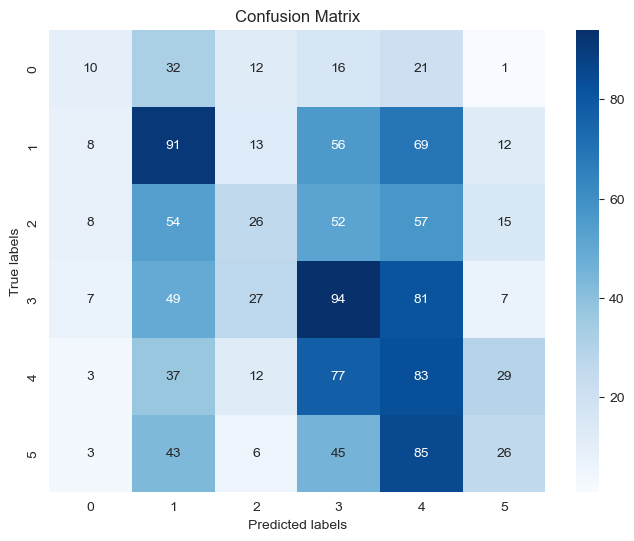

{'accuracy': 0.26045777426992894,
 'precision': 0.2674993298327715,
 'recall': 0.26045777426992894,
 'f1': 0.24699150788108068}

In [109]:
# evaluate bilstm_gru_model_custom and make prediction and plot confusion matrix
evaluation = bilstm_gru_model_custom.evaluate(X_test_custom, Y_test)
best_model_bilstm_gru_custom = load_model('best_model_bilstm_gru_custom.h5')

bilstm_gru_model_custom_predictions = best_model_bilstm_gru_custom.predict(X_test_custom)
plot_matrix(bilstm_gru_model_custom_predictions)

## Binary-BILSTM-GRU

In [73]:
def create_bilstm_gru_model_binary(vocab_size, embedding_dim, embedding_matrix, input_length, learning_rate):
    inputs = Input(shape=(input_length,))
    embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=input_length, trainable=False)(inputs)
    bilstm = Bidirectional(LSTM(50, return_sequences=True))(embedding)
    bigru, forward_h, backward_h = Bidirectional(GRU(50, return_sequences=True, return_state=True))(embedding)
    max_pool_lstm = GlobalMaxPooling1D()(bilstm)
    max_pool_gru = GlobalMaxPooling1D()(bigru)
    avg_pool_lstm = GlobalAveragePooling1D()(bilstm)
    avg_pool_gru = GlobalAveragePooling1D()(bigru)
    state_h = Concatenate()([forward_h, backward_h])
    concat = Concatenate()([max_pool_lstm, max_pool_gru, avg_pool_lstm, avg_pool_gru, state_h])
    output = Dense(1, activation='sigmoid')(concat)
    model = Model(inputs=inputs, outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


### SPACY WORD ID

In [92]:
# BILSTM_GRU_SPACY_BINARY WITH CLASS WEIGHT RESTORE BEST WEIGHTS TRUE
vocab_size = len(vocabulary_dict_spacy) + 1
embedding_dim = 300
embedding_matrix = embedding_matrix_spacy_300d
# pad_len = 35
learning_rate = 0.00025

bilstm_gru_model_spacy_binary = create_bilstm_gru_model_binary(vocab_size, embedding_dim, embedding_matrix, pad_len, learning_rate)

# model checkpoint
model_checkpoint_bilstm_gru_spacy = ModelCheckpoint(filepath='best_model_bilstm_gru_spacy_binary.h5', monitor='val_accuracy', save_best_only=True)
# early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

class_weight = {0: 1.1304960541149944, 1: 0.8965131873044255}

bilstm_gru_model_spacy_binary.fit(X_train_spacy, Y_train_binary, epochs=15, batch_size=64, validation_data=(X_val_spacy, Y_val_binary), callbacks=[early_stopping, model_checkpoint_bilstm_gru_spacy], class_weight=class_weight)


Epoch 1/15
160/160 [==============================] - 16s 65ms/step - loss: 0.6767 - accuracy: 0.5739 - val_loss: 0.6638 - val_accuracy: 0.5919
Epoch 2/15
160/160 [==============================] - 9s 55ms/step - loss: 0.6569 - accuracy: 0.6078 - val_loss: 0.6573 - val_accuracy: 0.6020
Epoch 3/15
160/160 [==============================] - 9s 57ms/step - loss: 0.6449 - accuracy: 0.6296 - val_loss: 0.6520 - val_accuracy: 0.6044
Epoch 4/15
160/160 [==============================] - 10s 61ms/step - loss: 0.6337 - accuracy: 0.6472 - val_loss: 0.6506 - val_accuracy: 0.6044
Epoch 5/15
160/160 [==============================] - 9s 58ms/step - loss: 0.6210 - accuracy: 0.6617 - val_loss: 0.6492 - val_accuracy: 0.6129
Epoch 6/15
160/160 [==============================] - 9s 58ms/step - loss: 0.6094 - accuracy: 0.6745 - val_loss: 0.6505 - val_accuracy: 0.6129
Epoch 7/15
160/160 [==============================] - 9s 58ms/step - loss: 0.5971 - accuracy: 0.6883 - val_loss: 0.6511 - val_accuracy: 0.62

40/40 [==============================] - 2s 18ms/step
Test set accuracy: 0.61
Test set precision: 0.61
Test set recall: 0.61
Test set F1 score: 0.61
[[300 253]
 [238 476]]


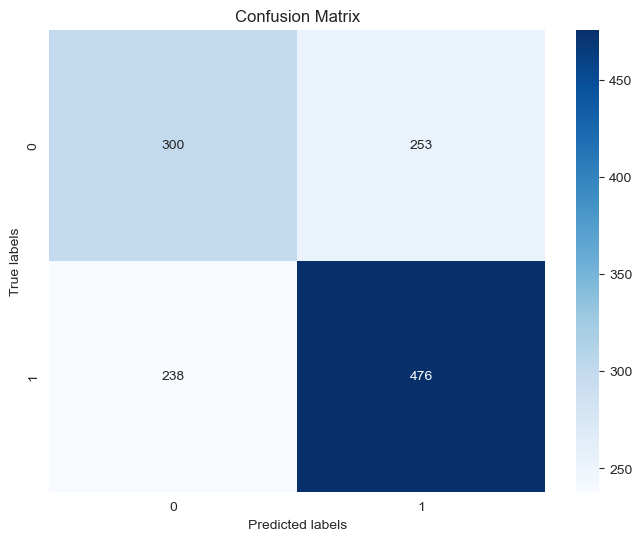

{'accuracy': 0.6124704025256511,
 'precision': 0.6113418102482482,
 'recall': 0.6124704025256511,
 'f1': 0.6118205456437399}

In [93]:
# BILSTM_GRU_SPACY_BINARY WITH CLASS WEIGHT RESTORE BEST WEIGHTS TRUE evaluation
evaluation = bilstm_gru_model_spacy_binary.evaluate(X_test_spacy, Y_test_binary)
best_model_bilstm_gru_spacy_binary = load_model('best_model_bilstm_gru_spacy_binary.h5')

bilstm_gru_model_spacy_binary_predictions = best_model_bilstm_gru_spacy_binary.predict(X_test_spacy)
plot_matrix_binary(bilstm_gru_model_spacy_binary_predictions)

In [94]:
# BILSTM_GRU_SPACY_BINARY WITHOUT CLASS WEIGHT RESTORE BEST WEIGHTS TRUE
vocab_size = len(vocabulary_dict_spacy) + 1
embedding_dim = 300
embedding_matrix = embedding_matrix_spacy_300d
# pad_len = 35
learning_rate = 0.00025

bilstm_gru_model_spacy_binary = create_bilstm_gru_model_binary(vocab_size, embedding_dim, embedding_matrix, pad_len, learning_rate)

# model checkpoint
model_checkpoint_bilstm_gru_spacy = ModelCheckpoint(filepath='best_model_bilstm_gru_spacy_binary2.h5', monitor='val_accuracy', save_best_only=True)
# early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

bilstm_gru_model_spacy_binary.fit(X_train_spacy, Y_train_binary, epochs=15, batch_size=64, validation_data=(X_val_spacy, Y_val_binary), callbacks=[early_stopping, model_checkpoint_bilstm_gru_spacy])

Epoch 1/15
160/160 [==============================] - 17s 66ms/step - loss: 0.6683 - accuracy: 0.5864 - val_loss: 0.6625 - val_accuracy: 0.6005
Epoch 2/15
160/160 [==============================] - 9s 56ms/step - loss: 0.6489 - accuracy: 0.6225 - val_loss: 0.6563 - val_accuracy: 0.6145
Epoch 3/15
160/160 [==============================] - 9s 57ms/step - loss: 0.6370 - accuracy: 0.6401 - val_loss: 0.6507 - val_accuracy: 0.6231
Epoch 4/15
160/160 [==============================] - 9s 58ms/step - loss: 0.6260 - accuracy: 0.6523 - val_loss: 0.6493 - val_accuracy: 0.6176
Epoch 5/15
160/160 [==============================] - 9s 59ms/step - loss: 0.6160 - accuracy: 0.6655 - val_loss: 0.6483 - val_accuracy: 0.6269
Epoch 6/15
160/160 [==============================] - 10s 64ms/step - loss: 0.6024 - accuracy: 0.6842 - val_loss: 0.6533 - val_accuracy: 0.6285
Epoch 7/15
160/160 [==============================] - 9s 59ms/step - loss: 0.5902 - accuracy: 0.6899 - val_loss: 0.6596 - val_accuracy: 0.62

40/40 [==============================] - 2s 18ms/step
Test set accuracy: 0.63
Test set precision: 0.63
Test set recall: 0.63
Test set F1 score: 0.62
[[251 302]
 [162 552]]


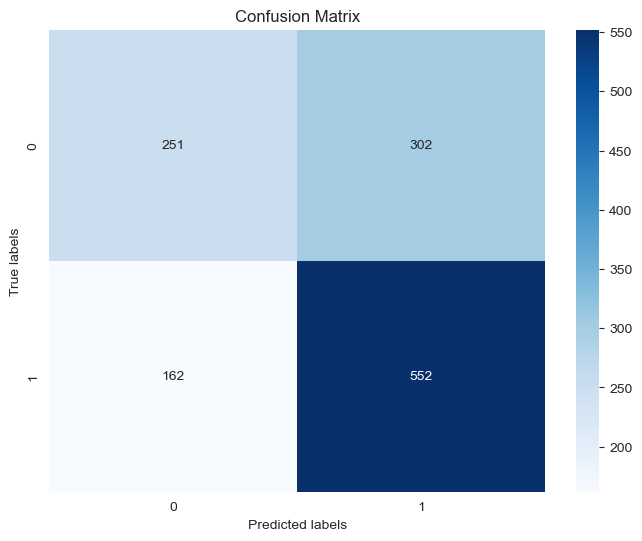

{'accuracy': 0.6337805840568271,
 'precision': 0.6295129774933096,
 'recall': 0.6337805840568271,
 'f1': 0.6235920262892569}

In [95]:
# BILSTM_GRU_SPACY_BINARY WITHOUT CLASS WEIGHT RESTORE BEST WEIGHTS TRUE evaluation
evaluation = bilstm_gru_model_spacy_binary.evaluate(X_test_spacy, Y_test_binary)
best_model_bilstm_gru_spacy_binary = load_model('best_model_bilstm_gru_spacy_binary2.h5')

bilstm_gru_model_spacy_binary_predictions = best_model_bilstm_gru_spacy_binary.predict(X_test_spacy)
plot_matrix_binary(bilstm_gru_model_spacy_binary_predictions)

Class weights sometimes negatively impacted f1 score. The model is still overpredicting the negative class.

### CUSTOM WORD ID

In [103]:
# BILSTM_GRU_CUSTOM_BINARY WITHOUT CLASS WEIGHT RESTORE BEST WEIGHTS TRUE
vocab_size = len(vocabulary_dict_custom) + 1
embedding_dim = 300
embedding_matrix = embedding_matrix_custom_300d
# pad_len = 35
learning_rate = 0.00025

bilstm_gru_model_custom_binary = create_bilstm_gru_model_binary(vocab_size, embedding_dim, embedding_matrix, pad_len, learning_rate)

# model checkpoint
model_checkpoint_bilstm_gru_custom = ModelCheckpoint(filepath='best_model_bilstm_gru_custom_binary.h5', monitor='val_accuracy', save_best_only=True)
# early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

bilstm_gru_model_custom_binary.fit(X_train_custom, Y_train_binary, epochs=15, batch_size=64, validation_data=(X_val_custom, Y_val_binary), callbacks=[early_stopping, model_checkpoint_bilstm_gru_custom], class_weight=class_weight)

Epoch 1/15
160/160 [==============================] - 18s 71ms/step - loss: 0.6727 - accuracy: 0.5783 - val_loss: 0.6541 - val_accuracy: 0.6199
Epoch 2/15
160/160 [==============================] - 9s 57ms/step - loss: 0.6525 - accuracy: 0.6167 - val_loss: 0.6457 - val_accuracy: 0.6394
Epoch 3/15
160/160 [==============================] - 10s 60ms/step - loss: 0.6397 - accuracy: 0.6370 - val_loss: 0.6414 - val_accuracy: 0.6417
Epoch 4/15
160/160 [==============================] - 9s 59ms/step - loss: 0.6277 - accuracy: 0.6502 - val_loss: 0.6426 - val_accuracy: 0.6301
Epoch 5/15
160/160 [==============================] - 9s 59ms/step - loss: 0.6181 - accuracy: 0.6609 - val_loss: 0.6396 - val_accuracy: 0.6394
Epoch 6/15
160/160 [==============================] - 9s 58ms/step - loss: 0.6045 - accuracy: 0.6750 - val_loss: 0.6422 - val_accuracy: 0.6363


40/40 [==============================] - 2s 17ms/step
Test set accuracy: 0.61
Test set precision: 0.61
Test set recall: 0.61
Test set F1 score: 0.61
[[317 236]
 [260 454]]


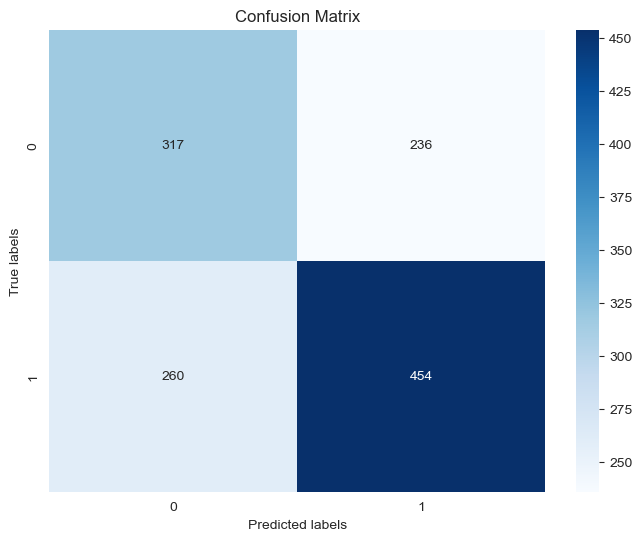

{'accuracy': 0.6085240726124704,
 'precision': 0.6105807911655499,
 'recall': 0.6085240726124704,
 'f1': 0.6093353910006725}

In [104]:
# evaluate the above model
evaluation = bilstm_gru_model_custom_binary.evaluate(X_test_custom, Y_test_binary)
best_model_bilstm_gru_custom_binary = load_model('best_model_bilstm_gru_custom_binary.h5')

bilstm_gru_model_custom_binary_predictions = best_model_bilstm_gru_custom_binary.predict(X_test_custom)
plot_matrix_binary(bilstm_gru_model_custom_binary_predictions)


## IGNORE BELOW

40/40 [==============================] - 5s 86ms/step
Test set accuracy: 0.62
Test set precision: 0.62
Test set recall: 0.62
Test set F1 score: 0.62
[[288 265]
 [212 502]]


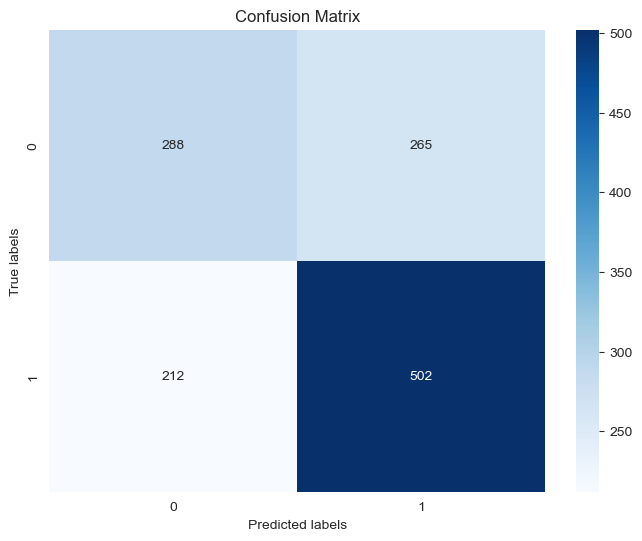

{'accuracy': 0.6235201262825573,
 'precision': 0.6202364669696817,
 'recall': 0.6235201262825573,
 'f1': 0.6207820346542503}

In [46]:
# BILSTM_GRU_SPACY_BINARY WITH CLASS WEIGHT RESTORE BEST WEIGHTS TRUE evaluation
evaluation = bilstm_gru_model_spacy_binary.evaluate(X_test_spacy, Y_test_binary)
best_model_bilstm_gru_spacy_binary = load_model('best_model_bilstm_gru_spacy_binary.h5')

bilstm_gru_model_spacy_binary_predictions = best_model_bilstm_gru_spacy_binary.predict(X_test_spacy)
plot_matrix_binary(bilstm_gru_model_spacy_binary_predictions)

In [38]:
# Create the BiLSTM-GRU model
vocab_size = len(vocabulary_dict_spacy) + 1
embedding_dim = 300
embedding_matrix = embedding_matrix_spacy_300d
# input_length = 30 # same as max_len
learning_rate = 0.00025

bilstm_gru_model_spacy_binary = create_bilstm_gru_model_binary(vocab_size, embedding_dim, embedding_matrix, pad_len, learning_rate)

# model checkpoint
model_checkpoint_bilstm_gru_spacy = ModelCheckpoint(filepath='best_model_bilstm_gru_spacy_binary2.h5', monitor='val_accuracy', save_best_only=True)
# early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=False)

bilstm_gru_model_spacy_binary.fit(X_train_spacy, Y_train_binary, epochs=15, batch_size=128, validation_data=(X_val_spacy, Y_val_binary), callbacks=[early_stopping, model_checkpoint_bilstm_gru_spacy])


Epoch 1/15
80/80 [==============================] - 14s 103ms/step - loss: 0.6719 - accuracy: 0.5700 - val_loss: 0.6666 - val_accuracy: 0.5997
Epoch 2/15
80/80 [==============================] - 6s 72ms/step - loss: 0.6547 - accuracy: 0.6115 - val_loss: 0.6591 - val_accuracy: 0.6059
Epoch 3/15
80/80 [==============================] - 6s 71ms/step - loss: 0.6452 - accuracy: 0.6298 - val_loss: 0.6549 - val_accuracy: 0.6121
Epoch 4/15
80/80 [==============================] - 6s 70ms/step - loss: 0.6354 - accuracy: 0.6440 - val_loss: 0.6510 - val_accuracy: 0.6262
Epoch 5/15
80/80 [==============================] - 6s 69ms/step - loss: 0.6257 - accuracy: 0.6574 - val_loss: 0.6572 - val_accuracy: 0.6207
Epoch 6/15
80/80 [==============================] - 6s 70ms/step - loss: 0.6181 - accuracy: 0.6628 - val_loss: 0.6536 - val_accuracy: 0.6269
Epoch 7/15
80/80 [==============================] - 6s 70ms/step - loss: 0.6083 - accuracy: 0.6735 - val_loss: 0.6507 - val_accuracy: 0.6114
Epoch 8/15


40/40 [==============================] - 2s 17ms/step
Test set accuracy: 0.62
Test set precision: 0.62
Test set recall: 0.62
Test set F1 score: 0.61
[[230 323]
 [153 561]]


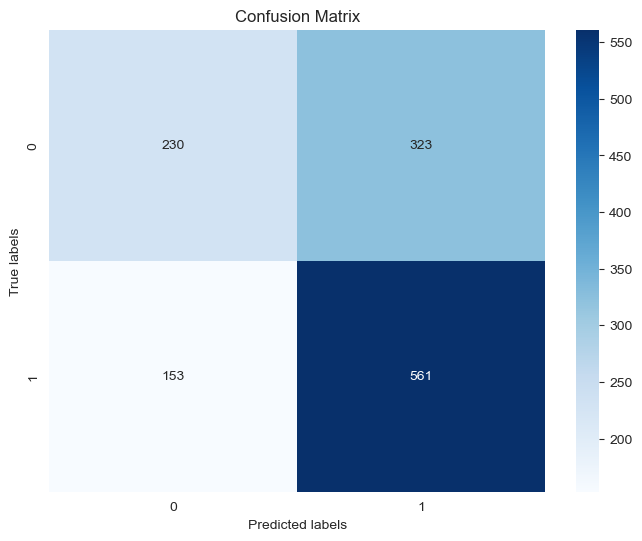

{'accuracy': 0.6243093922651933,
 'precision': 0.6197349309087117,
 'recall': 0.6243093922651933,
 'f1': 0.6101757326043208}

In [39]:
# evaluate bilstm_gru_model_spacy_binary and make prediction and plot confusion matrix
evaluation = bilstm_gru_model_spacy_binary.evaluate(X_test_spacy, Y_test_binary)
best_model_bilstm_gru_spacy_binary = load_model('best_model_bilstm_gru_spacy_binary2.h5')

bilstm_gru_model_spacy_binary_predictions = best_model_bilstm_gru_spacy_binary.predict(X_test_spacy)
plot_matrix_binary(bilstm_gru_model_spacy_binary_predictions)

In [60]:
# Create the BiLSTM-GRU model for binary classification on spacy without class weight
vocab_size = len(vocabulary_dict_spacy) + 1
embedding_dim = 300
embedding_matrix = embedding_matrix_spacy_300d
# pad_len = 35
learning_rate = 0.00025

bilstm_gru_model_spacy_binary = create_bilstm_gru_model_binary(vocab_size, embedding_dim, embedding_matrix, pad_len, learning_rate)

# model checkpoint
model_checkpoint_bilstm_gru_spacy = ModelCheckpoint(filepath='best_model_bilstm_gru_spacy_binary.h5', monitor='val_accuracy', save_best_only=True)
# early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=False)

# class_weight = {0: 1.1304960541149944, 1: 0.8965131873044255}

bilstm_gru_model_spacy_binary.fit(X_train_spacy, Y_train_binary, epochs=15, batch_size=64, validation_data=(X_val_spacy, Y_val_binary), callbacks=[early_stopping, model_checkpoint_bilstm_gru_spacy])#, class_weight=class_weight)

Epoch 1/15
160/160 [==============================] - 18s 64ms/step - loss: 0.6684 - accuracy: 0.5853 - val_loss: 0.6694 - val_accuracy: 0.5911
Epoch 2/15
160/160 [==============================] - 9s 53ms/step - loss: 0.6498 - accuracy: 0.6251 - val_loss: 0.6580 - val_accuracy: 0.6106
Epoch 3/15
160/160 [==============================] - 9s 53ms/step - loss: 0.6370 - accuracy: 0.6435 - val_loss: 0.6532 - val_accuracy: 0.6207
Epoch 4/15
160/160 [==============================] - 9s 54ms/step - loss: 0.6255 - accuracy: 0.6626 - val_loss: 0.6520 - val_accuracy: 0.6231
Epoch 5/15
160/160 [==============================] - 10s 60ms/step - loss: 0.6135 - accuracy: 0.6746 - val_loss: 0.6532 - val_accuracy: 0.6262
Epoch 6/15
160/160 [==============================] - 9s 57ms/step - loss: 0.6014 - accuracy: 0.6886 - val_loss: 0.6658 - val_accuracy: 0.6168
Epoch 7/15
160/160 [==============================] - 9s 55ms/step - loss: 0.5889 - accuracy: 0.6971 - val_loss: 0.6485 - val_accuracy: 0.62

40/40 [==============================] - 2s 17ms/step
Test set accuracy: 0.62
Test set precision: 0.62
Test set recall: 0.62
Test set F1 score: 0.62
[[262 291]
 [187 527]]


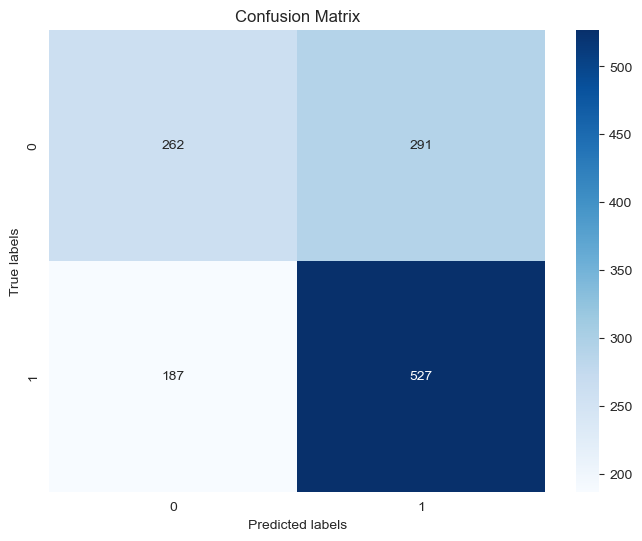

{'accuracy': 0.6227308602999211,
 'precision': 0.6177454805302478,
 'recall': 0.6227308602999211,
 'f1': 0.615957502648296}

In [61]:
# evaluate bilstm_gru_model_spacy_binary and make prediction and plot confusion matrix
evaluation = bilstm_gru_model_spacy_binary.evaluate(X_test_spacy, Y_test_binary)
best_model_bilstm_gru_spacy_binary = load_model('best_model_bilstm_gru_spacy_binary.h5')

bilstm_gru_model_spacy_binary_predictions = best_model_bilstm_gru_spacy_binary.predict(X_test_spacy)
plot_matrix_binary(bilstm_gru_model_spacy_binary_predictions)

# SPACY MULTICLASS

In [71]:
# Create the BiLSTM-GRU model for multiclass classification on spacy, NEW ADDITIONAL RETURN STATES
vocab_size = len(vocabulary_dict_spacy) + 1
embedding_dim = 300
embedding_matrix = embedding_matrix_spacy_300d
# pad_len = 35
learning_rate = 0.00025

bilstm_gru_model_spacy_returnstates = create_bilstm_gru_model(vocab_size, embedding_dim, embedding_matrix, pad_len, learning_rate)

# model checkpoint
model_checkpoint_bilstm_gru_spacy = ModelCheckpoint(filepath='best_model_bilstm_gru_spacy_return_states.h5', monitor='val_categorical_accuracy', save_best_only=True)
# early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=3, restore_best_weights=True)

# class_weight = {0: 1.1304960541149944, 1: 0.8965131873044255}

bilstm_gru_model_spacy_returnstates.fit(X_train_spacy, Y_train, epochs=15, batch_size=64, validation_data=(X_val_spacy, Y_val), callbacks=[early_stopping, model_checkpoint_bilstm_gru_spacy])#, class_weight=class_weight)

Epoch 1/15
160/160 [==============================] - 16s 65ms/step - loss: 1.7462 - categorical_accuracy: 0.2219 - val_loss: 1.7408 - val_categorical_accuracy: 0.2329
Epoch 2/15
160/160 [==============================] - 9s 56ms/step - loss: 1.7088 - categorical_accuracy: 0.2657 - val_loss: 1.7179 - val_categorical_accuracy: 0.2516
Epoch 3/15
160/160 [==============================] - 9s 56ms/step - loss: 1.6812 - categorical_accuracy: 0.2880 - val_loss: 1.7071 - val_categorical_accuracy: 0.2430
Epoch 4/15
160/160 [==============================] - 9s 56ms/step - loss: 1.6579 - categorical_accuracy: 0.3107 - val_loss: 1.7013 - val_categorical_accuracy: 0.2741
Epoch 5/15
160/160 [==============================] - 9s 56ms/step - loss: 1.6347 - categorical_accuracy: 0.3309 - val_loss: 1.7003 - val_categorical_accuracy: 0.2593
Epoch 6/15
160/160 [==============================] - 9s 55ms/step - loss: 1.6113 - categorical_accuracy: 0.3493 - val_loss: 1.7048 - val_categorical_accuracy: 0.26

40/40 [==============================] - 2s 17ms/step
Test set accuracy: 0.26
Test set precision: 0.26
Test set recall: 0.26
Test set F1 score: 0.24
[[  1  37  16  10  22   6]
 [  2  97  24  35  72  19]
 [  0  59  45  45  52  11]
 [  1  72  35  55  95   7]
 [  0  45  21  44 109  22]
 [  1  55  15  27  87  23]]


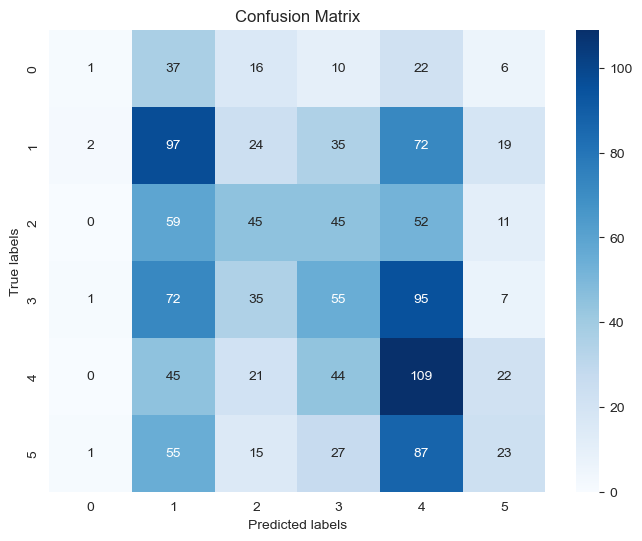

{'accuracy': 0.26045777426992894,
 'precision': 0.25862593942818746,
 'recall': 0.26045777426992894,
 'f1': 0.23901808275287106}

In [72]:
evaluation = bilstm_gru_model_spacy_returnstates.evaluate(X_test_spacy, Y_test)
best_model_bilstm_gru_spacy_returnstates = load_model('best_model_bilstm_gru_spacy_return_states.h5')

bilstm_gru_spacy_predictions = best_model_bilstm_gru_spacy_returnstates.predict(X_test_spacy)
plot_matrix(bilstm_gru_spacy_predictions)

In [292]:
len(vocabulary_dict_spacy)

9495

In [293]:
len(embedding_matrix)

9607

In [60]:
# Create the BiLSTM-GRU model
vocab_size = len(vocabulary_dict_spacy) + 1
embedding_dim = 300
embedding_matrix = embedding_matrix_spacy_300d
# input_length = 30 # same as max_len
learning_rate = 0.00025

bilstm_gru_model_spacy = create_bilstm_gru_model(vocab_size, embedding_dim, embedding_matrix, pad_len, learning_rate)

# model checkpoint
model_checkpoint_bilstm_gru_spacy = ModelCheckpoint(filepath='best_model_bilstm_gru_spacy.h5', monitor='val_categorical_accuracy', save_best_only=True)
# early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=3, restore_best_weights=False)

bilstm_gru_model_spacy.fit(X_train_spacy, Y_train, epochs=15, batch_size=128, validation_data=(X_val_spacy, Y_val), callbacks=[early_stopping, model_checkpoint_bilstm_gru_spacy])

Epoch 1/15
80/80 [==============================] - 13s 90ms/step - loss: 1.7576 - categorical_accuracy: 0.2081 - val_loss: 1.7448 - val_categorical_accuracy: 0.2290
Epoch 2/15
80/80 [==============================] - 6s 70ms/step - loss: 1.7219 - categorical_accuracy: 0.2556 - val_loss: 1.7289 - val_categorical_accuracy: 0.2407
Epoch 3/15
80/80 [==============================] - 6s 69ms/step - loss: 1.7010 - categorical_accuracy: 0.2773 - val_loss: 1.7190 - val_categorical_accuracy: 0.2570
Epoch 4/15
80/80 [==============================] - 6s 72ms/step - loss: 1.6828 - categorical_accuracy: 0.2961 - val_loss: 1.7166 - val_categorical_accuracy: 0.2593
Epoch 5/15
80/80 [==============================] - 5s 69ms/step - loss: 1.6634 - categorical_accuracy: 0.3100 - val_loss: 1.7219 - val_categorical_accuracy: 0.2593
Epoch 6/15
80/80 [==============================] - 6s 69ms/step - loss: 1.6470 - categorical_accuracy: 0.3187 - val_loss: 1.7091 - val_categorical_accuracy: 0.2601
Epoch 7/1

40/40 [==============================] - 2s 16ms/step
Test set accuracy: 0.26
Test set precision: 0.26
Test set recall: 0.26
Test set F1 score: 0.24
[[  7  44  10  11  17   3]
 [  7 114  20  37  48  23]
 [  3  81  34  42  38  14]
 [  5  87  30  62  71  10]
 [  2  58  16  54  84  27]
 [  7  66   4  37  67  27]]


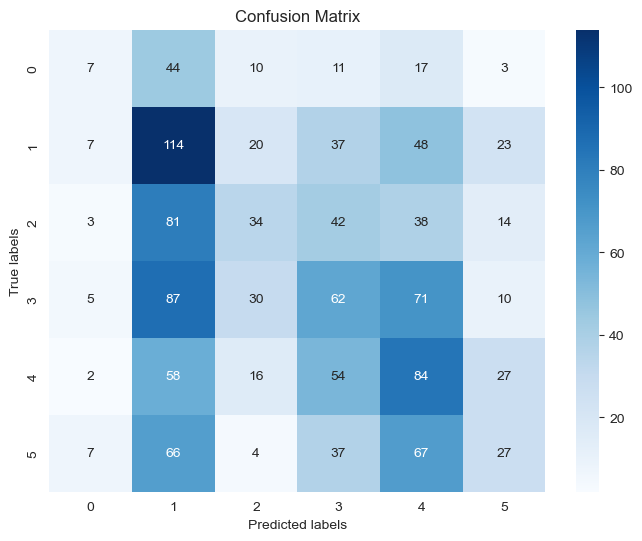

{'accuracy': 0.25887924230465664,
 'precision': 0.26123493545172555,
 'recall': 0.25887924230465664,
 'f1': 0.24319644515074718}

In [61]:
# evaluate bilstm_gru_model_spacy and make prediction and plot confusion matrix
evaluation = bilstm_gru_model_spacy.evaluate(X_test_spacy, Y_test)
best_model_bilstm_gru_spacy = load_model('best_model_bilstm_gru_spacy.h5')

bilstm_gru_spacy_predictions = best_model_bilstm_gru_spacy.predict(X_test_spacy)
plot_matrix(bilstm_gru_spacy_predictions)

In [100]:
# Create the BiLSTM-GRU model
vocab_size = len(vocabulary_dict_spacy) + 1
embedding_dim = 300
embedding_matrix = embedding_matrix_spacy_300d
# input_length = 30 # same as max_len
learning_rate = 0.00025

bilstm_gru_model_spacy = create_bilstm_gru_model(vocab_size, embedding_dim, embedding_matrix, pad_len, learning_rate)

# model checkpoint
model_checkpoint_bilstm_gru_spacy = ModelCheckpoint(filepath='best_model_bilstm_gru_spacy.h5', monitor='val_categorical_accuracy', save_best_only=True)
# early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=3, restore_best_weights=False)

bilstm_gru_model_spacy.fit(X_train_spacy, Y_train, epochs=15, batch_size=128, validation_data=(X_val_spacy, Y_val), callbacks=[early_stopping, model_checkpoint_bilstm_gru_spacy])

# # Obtain predictions
# dense_preds = dense_model.predict(X_test_meta)
# bilstm_gru_preds = bilstm_gru_model.predict(X_test_custom)
#
# # Ensemble voting
# val_accuracies = [dense_model.evaluate(X_val_meta,

Epoch 1/15
80/80 [==============================] - 11s 67ms/step - loss: 1.7552 - accuracy: 0.2087 - val_loss: 1.7420 - val_accuracy: 0.2329
Epoch 2/15
80/80 [==============================] - 4s 49ms/step - loss: 1.7209 - accuracy: 0.2530 - val_loss: 1.7252 - val_accuracy: 0.2516
Epoch 3/15
80/80 [==============================] - 4s 49ms/step - loss: 1.7004 - accuracy: 0.2685 - val_loss: 1.7196 - val_accuracy: 0.2461
Epoch 4/15
80/80 [==============================] - 4s 49ms/step - loss: 1.6812 - accuracy: 0.2917 - val_loss: 1.7078 - val_accuracy: 0.2578
Epoch 5/15
80/80 [==============================] - 4s 48ms/step - loss: 1.6639 - accuracy: 0.3036 - val_loss: 1.7052 - val_accuracy: 0.2492
Epoch 6/15
80/80 [==============================] - 4s 49ms/step - loss: 1.6460 - accuracy: 0.3287 - val_loss: 1.7049 - val_accuracy: 0.2438
Epoch 7/15
80/80 [==============================] - 4s 48ms/step - loss: 1.6281 - accuracy: 0.3427 - val_loss: 1.7087 - val_accuracy: 0.2539
Epoch 8/15
8

40/40 [==============================] - 2s 12ms/step
Test set accuracy: 0.26
Test set precision: 0.27
Test set recall: 0.26
Test set F1 score: 0.24
[[  3  39  10  24  10   6]
 [  3 104  15  76  35  16]
 [  3  49  30  82  33  15]
 [  1  74  17  98  63  12]
 [  1  57   7  90  64  22]
 [  4  52  12  58  51  31]]


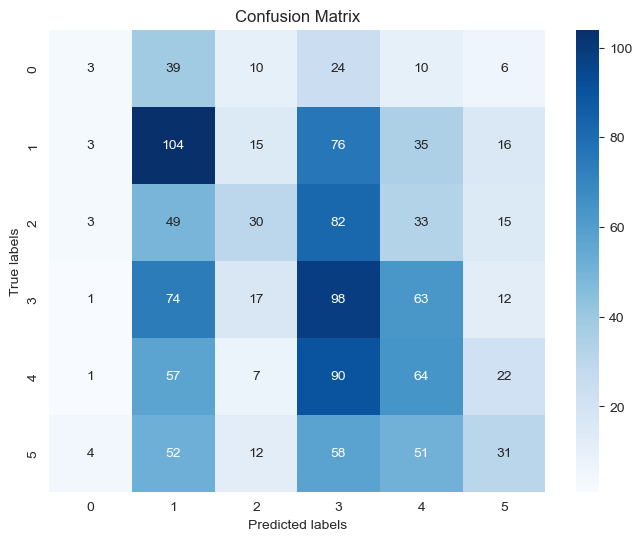

In [101]:
# evaluate bilstm_gru_model_spacy and make prediction and plot confusion matrix
evaluation = bilstm_gru_model_spacy.evaluate(X_test_spacy, Y_test)
best_model_bilstm_gru_spacy = load_model('best_model_bilstm_gru_spacy.h5')

bilstm_gru_spacy_predictions = best_model_bilstm_gru_spacy.predict(X_test_spacy)
plot_matrix(bilstm_gru_spacy_predictions)

In [103]:
# Create the BiLSTM-GRU model
vocab_size = len(vocabulary_dict_spacy) + 1
embedding_dim = 300
embedding_matrix = embedding_matrix_spacy_300d
# input_length = 30 # same as max_len
learning_rate = 0.00001

bilstm_gru_model_spacy = create_bilstm_gru_model(vocab_size, embedding_dim, embedding_matrix, pad_len, learning_rate)

# model checkpoint
model_checkpoint_bilstm_gru_spacy = ModelCheckpoint(filepath='best_model_bilstm_gru_spacy.h5', monitor='val_categorical_accuracy', save_best_only=True)
# early stopping
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=3, restore_best_weights=False)

bilstm_gru_model_spacy.fit(X_train_spacy, Y_train, epochs=70, batch_size=128, validation_data=(X_val_spacy, Y_val), callbacks=[early_stopping, model_checkpoint_bilstm_gru_spacy])

Epoch 1/70
80/80 [==============================] - 11s 74ms/step - loss: 1.8085 - accuracy: 0.1490 - val_loss: 1.8050 - val_accuracy: 0.1659
Epoch 2/70
80/80 [==============================] - 4s 48ms/step - loss: 1.7897 - accuracy: 0.1856 - val_loss: 1.7897 - val_accuracy: 0.1830
Epoch 3/70
80/80 [==============================] - 4s 48ms/step - loss: 1.7771 - accuracy: 0.1951 - val_loss: 1.7788 - val_accuracy: 0.1955
Epoch 4/70
80/80 [==============================] - 4s 49ms/step - loss: 1.7682 - accuracy: 0.2038 - val_loss: 1.7716 - val_accuracy: 0.2025
Epoch 5/70
80/80 [==============================] - 4s 48ms/step - loss: 1.7619 - accuracy: 0.2062 - val_loss: 1.7661 - val_accuracy: 0.2064
Epoch 6/70
80/80 [==============================] - 4s 48ms/step - loss: 1.7572 - accuracy: 0.2122 - val_loss: 1.7623 - val_accuracy: 0.2040
Epoch 7/70
80/80 [==============================] - 4s 48ms/step - loss: 1.7536 - accuracy: 0.2151 - val_loss: 1.7593 - val_accuracy: 0.2017
Epoch 8/70
8

40/40 [==============================] - 2s 12ms/step
Test set accuracy: 0.26
Test set precision: 0.24
Test set recall: 0.26
Test set F1 score: 0.22
[[  0  46   3  22  14   7]
 [  0 109  11  72  47  10]
 [  1  74  20  71  41   5]
 [  0  87   9 108  58   3]
 [  0  54  12  86  76  13]
 [  0  61   5  64  67  11]]


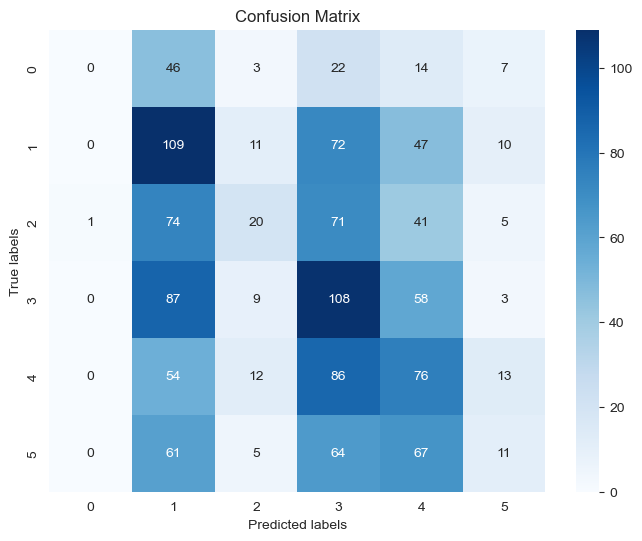

In [104]:
# evaluate bilstm_gru_model_spacy and make prediction and plot confusion matrix LR 0.00001
evaluation = bilstm_gru_model_spacy.evaluate(X_test_spacy, Y_test)
best_model_bilstm_gru_spacy = load_model('best_model_bilstm_gru_spacy.h5')

bilstm_gru_spacy_predictions = best_model_bilstm_gru_spacy.predict(X_test_spacy)
plot_matrix(bilstm_gru_spacy_predictions)

40/40 [==============================] - 2s 14ms/step
Test set accuracy: 0.25
Test set precision: 0.27
Test set recall: 0.25
Test set F1 score: 0.22
[[  1  44  11  15  19   2]
 [  1 117  10  49  60  12]
 [  1  82  26  58  39   6]
 [  0  95  15  76  72   7]
 [  0  59   9  77  82  14]
 [  0  74   4  55  59  16]]


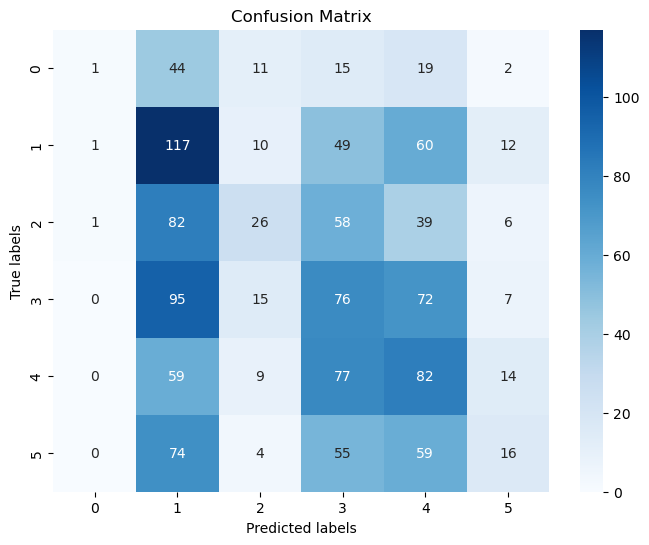

In [313]:
# evaluate bilstm_gru_model_spacy and make prediction and plot confusion matrix LR DEFAULT
evaluation = bilstm_gru_model_spacy.evaluate(X_test_spacy, Y_test)
best_model_bilstm_gru_spacy = load_model('best_model_bilstm_gru_spacy.h5')

bilstm_gru_spacy_predictions = best_model_bilstm_gru_spacy.predict(X_test_spacy)
plot_matrix(bilstm_gru_spacy_predictions)

# ENSEMBLE MAJORITY VOTING

Test set accuracy: 0.26
Test set precision: 0.26
Test set recall: 0.26
Test set F1 score: 0.24
[[  7  44  10  11  17   3]
 [  7 114  20  37  48  23]
 [  3  81  34  42  38  14]
 [  5  87  30  62  71  10]
 [  2  58  16  54  84  27]
 [  7  66   4  37  67  27]]


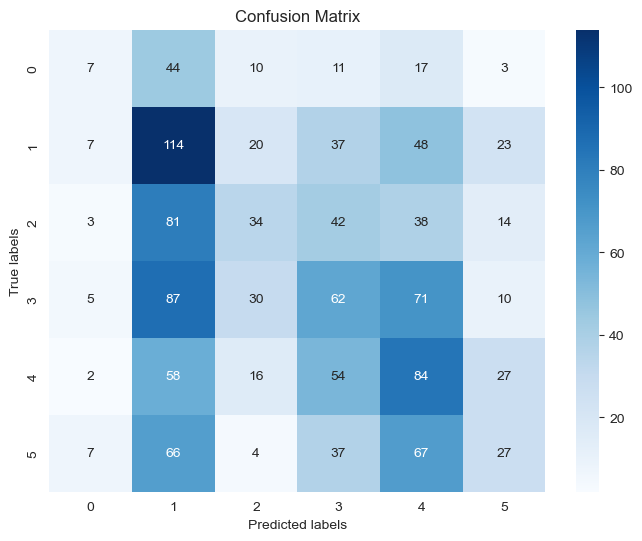

In [62]:
bilstm_gru_model_spacy_metrics = plot_matrix(bilstm_gru_spacy_predictions)

Test set accuracy: 0.26
Test set precision: 0.15
Test set recall: 0.26
Test set F1 score: 0.19
[[  0  65   0  12  15   0]
 [  0 147   0  50  52   0]
 [  0 117   0  34  61   0]
 [  0 119   0  63  83   0]
 [  0  71   0  55 115   0]
 [  0  75   0  34  99   0]]


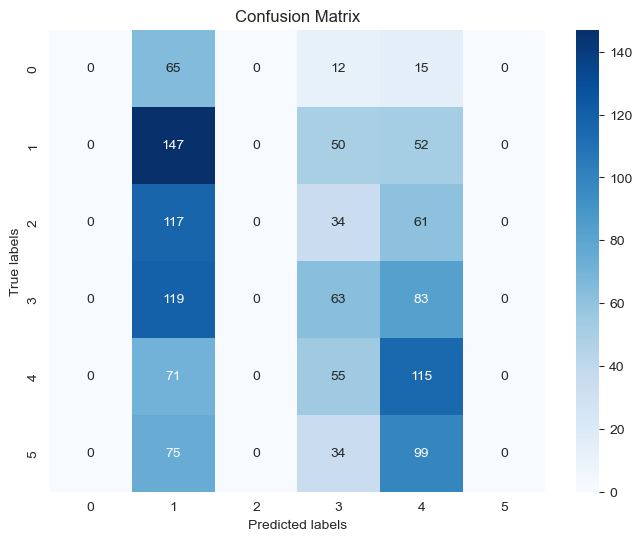

In [64]:
dense_model_jaccard_pfine_dfine_metrics = plot_matrix(dense_model_jaccard_pfine_dfine_predictions)

In [79]:
dense_model_jaccard_pfine_dfine_weight = dense_model_jaccard_pfine_dfine_metrics['f1'] / (dense_model_jaccard_pfine_dfine_metrics['f1'] + bilstm_gru_model_spacy_metrics['f1'])
bilstm_gru_model_spacy_weight = bilstm_gru_model_spacy_metrics['f1'] / (dense_model_jaccard_pfine_dfine_metrics['f1'] + bilstm_gru_model_spacy_metrics['f1'])

In [80]:
dense_preds_bin = (dense_model_jaccard_pfine_dfine_predictions > 0.5).astype(int)
lstm_gru_preds_bin = (bilstm_gru_spacy_predictions > 0.5).astype(int)

In [81]:
weighted_preds = dense_preds_bin * dense_model_jaccard_pfine_dfine_weight + lstm_gru_preds_bin * bilstm_gru_model_spacy_weight
final_preds = (weighted_preds >= 0.5).astype(int)

Test set accuracy: 0.20
Test set precision: 0.13
Test set recall: 0.20
Test set F1 score: 0.13
[[ 25  57   3   7   0   0]
 [ 35 185  14  15   0   0]
 [ 36 148  13  14   0   1]
 [ 26 176  30  33   0   0]
 [ 15 168  32  26   0   0]
 [ 16 141  19  30   2   0]]


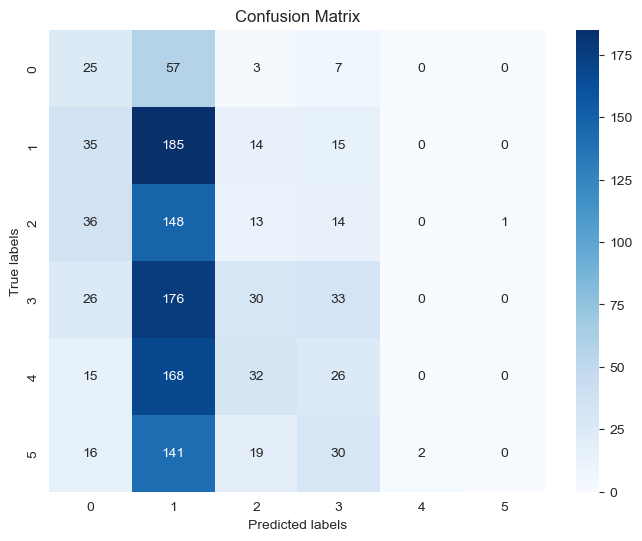

In [82]:
ensemble_metrics = plot_matrix(final_preds)

Test set accuracy: 0.22
Test set precision: 0.19
Test set recall: 0.22
Test set F1 score: 0.14
[[  6  72   2  12   0   0]
 [  8 202  10  29   0   0]
 [  3 173  11  24   1   0]
 [  2 186  20  56   1   0]
 [  3 161   9  66   2   0]
 [  5 128   4  68   3   0]]


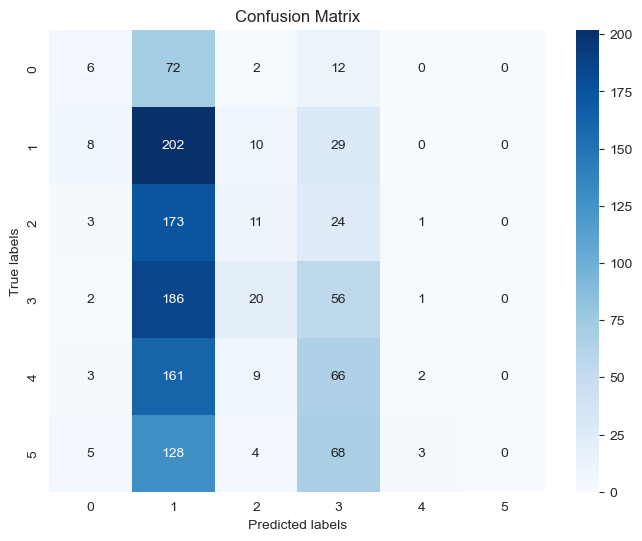

In [119]:
# binarize the predictions (threshold = 0.5)
dense_preds_bin = (dense_model_jaccard_pfine_dcustom_predictions > 0.5).astype(int)
lstm_gru_preds_bin = (bilstm_gru_spacy_predictions > 0.5).astype(int)

# Majority voting
combined_preds = (dense_preds_bin + lstm_gru_preds_bin) / 2
final_preds = (combined_preds >= 0.5).astype(int)

plot_matrix(final_preds)

Test set accuracy: 0.22
Test set precision: 0.19
Test set recall: 0.22
Test set F1 score: 0.14
[[  6  72   2  12   0   0]
 [  8 202  10  29   0   0]
 [  3 173  11  24   1   0]
 [  2 186  20  56   1   0]
 [  3 161   9  66   2   0]
 [  5 128   4  68   3   0]]


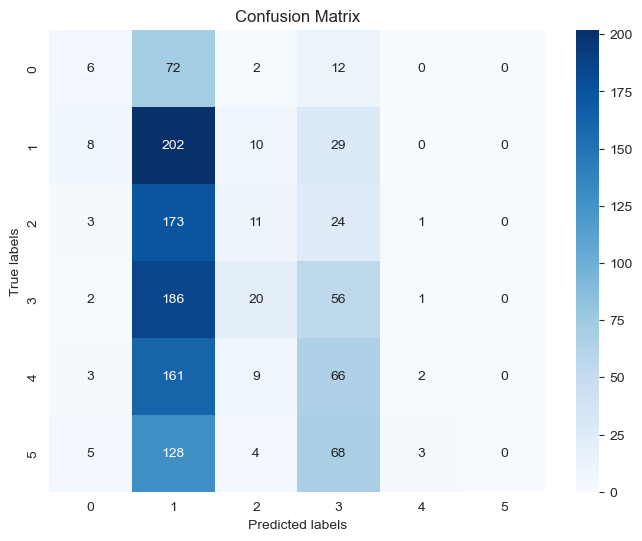

In [317]:
# EXPORT data as pickle
train_data.to_pickle('processed_train_data_v4.p')
val_data.to_pickle('processed_val_data_v4.p')
test_data.to_pickle('processed_test_data_v4.p')

In [316]:
train_data.head()

,index,id,label,statement,subject,speaker,job-title,party,barely-true-counts,false-counts,...,dep-id-fine,dep-id-custom,statement-customswr,statement-spacyswr,job-id-jaccard,party-id-jaccard,context-id-jaccard,subject-id-jaccard,word-id-custom,word-id-spacy
0,0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,republican,0.0,1.0,...,"[8, 8, 4, 4, 3, 1, 8, 3, 8, 7, 2, 8, 8, 8]","[7, 5, 11, 11, 8, 6, 11, 8, 1, 4, 9, 2, 3, 1]",say annies list political group support third ...,say annies list political group support trimes...,2,0,13,2,"[3, 5440, 717, 493, 396, 54, 274, 4039, 155, 1...","[1, 5315, 633, 423, 332, 37, 3919, 120, 936]"
1,1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,democrat,0.0,0.0,...,"[8, 8, 8, 1, 8, 7, 8, 8, 1, 8, 8, 3, 1, 8, 8, ...","[11, 7, 5, 6, 2, 4, 3, 1, 6, 7, 11, 8, 6, 11, ...",when do decline coal start start when natural ...,decline coal start start natural gas take star...,6,1,0,5,"[37, 9, 804, 861, 308, 308, 37, 981, 254, 39, ...","[720, 773, 249, 249, 891, 204, 46, 249, 527, 1..."
2,2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,democrat,70.0,71.0,...,"[7, 1, 8, 8, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 2, ...","[4, 6, 7, 2, 4, 3, 1, 2, 11, 10, 11, 4, 11, 5,...",hillary clinton agree john mccain vote give ge...,hillary clinton agree john mccain vote george ...,2,1,3,5,"[104, 69, 734, 160, 201, 18, 89, 262, 137, 258...","[74, 49, 649, 125, 157, 12, 212, 103, 208, 274..."
3,3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,unknown,none,7.0,19.0,...,"[7, 7, 7, 1, 8, 8, 8, 8, 3, 7, 7, 2, 8]","[4, 4, 4, 6, 7, 11, 10, 11, 8, 4, 4, 9, 1]",health care reform legislation be likely manda...,health care reform legislation likely mandate ...,0,2,0,0,"[19, 22, 209, 252, 1, 592, 406, 361, 439, 176,...","[13, 16, 165, 202, 514, 342, 301, 372, 140, 2747]"
4,4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,unknown,democrat,15.0,9.0,...,"[8, 3, 1, 8, 8, 8, 8, 8, 8, 8, 8]","[5, 8, 6, 7, 2, 5, 3, 2, 11, 3, 1]",economic turnaround start end term,economic turnaround start end term,0,1,3,6,"[282, 3331, 308, 247, 248]","[224, 3208, 249, 198, 199]"


# MULTI INPUT BISLTM-GRU
## Unused due to poor performance

In [51]:
def create_bilstm_gru_model_multiinput(vocab_size, vocab_size_pos, vocab_size_dep, embedding_dim, embedding_matrix, input_length, learning_rate):
    # Define input layers
    inputs_word = Input(shape=(input_length,), name="word_input")
    inputs_pos = Input(shape=(input_length,), name="pos_input")
    inputs_dep = Input(shape=(input_length,), name="dep_input")

    # Word Embeddings
    embedding_word = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=input_length, trainable=False)(inputs_word)

    # POS and DEP Embeddings
    embedding_pos = Embedding(vocab_size_pos, 16)(inputs_pos)
    embedding_dep = Embedding(vocab_size_dep, 16)(inputs_dep)

    # Concatenate embeddings
    concat_embeddings = Concatenate()([embedding_word, embedding_pos, embedding_dep])

    # LSTM and GRU layers
    bilstm = Bidirectional(LSTM(50, return_sequences=True))(concat_embeddings)
    bigru = Bidirectional(GRU(50, return_sequences=True))(concat_embeddings)

    # Pooling layers
    max_pool_lstm = GlobalMaxPooling1D()(bilstm)
    max_pool_gru = GlobalMaxPooling1D()(bigru)
    avg_pool_lstm = GlobalAveragePooling1D()(bilstm)
    avg_pool_gru = GlobalAveragePooling1D()(bigru)

    # Concatenate pooling
    concat = Concatenate()([max_pool_lstm, max_pool_gru, avg_pool_lstm, avg_pool_gru])
    output = Dense(6, activation='sigmoid')(concat)

    model = Model(inputs=[inputs_word, inputs_pos, inputs_dep], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model


In [54]:
# Initial parameters
vocab_size = len(vocabulary_dict_spacy) + 1
vocab_size_pos = max(pos_dict_fine.values()) + 1 # fine grained POS
vocab_size_dep = max(dep_dict_fine.values()) + 1 # fine grained DEP
embedding_dim = 300
embedding_matrix = embedding_matrix_spacy_300d
learning_rate = 0.00025

# Create the model
bilstm_gru_spacy_pfine_dfine = create_bilstm_gru_model_multiinput(vocab_size, vocab_size_pos, vocab_size_dep, embedding_dim, embedding_matrix, pad_len, learning_rate)

# Set up checkpoints and early stopping
model_checkpoint_bilstm_gru_spacy = ModelCheckpoint(filepath='best_model_bilstm_gru_spacy_pfine_dfine.h5', monitor='val_categorical_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=3, restore_best_weights=True)

# Call fit function
bilstm_gru_spacy_pfine_dfine.fit([X_train_spacy, X_train_pos_fine, X_train_dep_fine], Y_train, epochs=15, batch_size=128, validation_data=([X_val_spacy, X_val_pos_fine, X_val_dep_fine], Y_val), callbacks=[early_stopping, model_checkpoint_bilstm_gru_spacy])


Epoch 1/15
80/80 [==============================] - 17s 130ms/step - loss: 1.7538 - categorical_accuracy: 0.2165 - val_loss: 1.7399 - val_categorical_accuracy: 0.2173
Epoch 2/15
80/80 [==============================] - 8s 97ms/step - loss: 1.7203 - categorical_accuracy: 0.2539 - val_loss: 1.7322 - val_categorical_accuracy: 0.2313
Epoch 3/15
80/80 [==============================] - 8s 100ms/step - loss: 1.6999 - categorical_accuracy: 0.2784 - val_loss: 1.7191 - val_categorical_accuracy: 0.2461
Epoch 4/15
80/80 [==============================] - 8s 99ms/step - loss: 1.6807 - categorical_accuracy: 0.2992 - val_loss: 1.7205 - val_categorical_accuracy: 0.2570
Epoch 5/15
80/80 [==============================] - 8s 102ms/step - loss: 1.6639 - categorical_accuracy: 0.3102 - val_loss: 1.7088 - val_categorical_accuracy: 0.2469
Epoch 6/15
80/80 [==============================] - 8s 100ms/step - loss: 1.6472 - categorical_accuracy: 0.3203 - val_loss: 1.7028 - val_categorical_accuracy: 0.2555
Epoch

40/40 [==============================] - 2s 17ms/step
Test set accuracy: 0.25
Test set precision: 0.24
Test set recall: 0.25
Test set F1 score: 0.21
[[  0  58   2  16   8   8]
 [  1 140   0  36  40  32]
 [  0 111   3  43  38  17]
 [  0 121   2  62  61  19]
 [  0  82   2  51  76  30]
 [  0  79   2  29  63  35]]


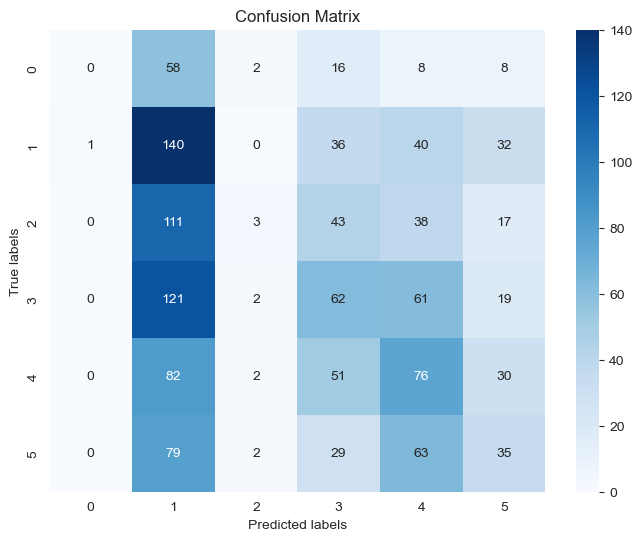

{'accuracy': 0.2494080505130229,
 'precision': 0.23820127199863514,
 'recall': 0.2494080505130229,
 'f1': 0.2094647492861016}

In [55]:
# evaluate best_model_bilstm_gru_spacy_pfine_dfine and make prediction and plot confusion matrix
evaluation = bilstm_gru_spacy_pfine_dfine.evaluate([X_test_spacy, X_test_pos_fine, X_test_dep_fine], Y_test)
best_model_bilstm_gru_spacy_pfine_dfine = load_model('best_model_bilstm_gru_spacy_pfine_dfine.h5')

bilstm_gru_spacy_pfine_dfine_predictions = best_model_bilstm_gru_spacy_pfine_dfine.predict([X_test_spacy, X_test_pos_fine, X_test_dep_fine])
plot_matrix(bilstm_gru_spacy_pfine_dfine_predictions)

In [56]:
def create_bilstm_gru_model_multiinput_binary(vocab_size, embedding_dim, embedding_matrix, input_length, vocab_size_pos, vocab_size_dep, learning_rate):
    # Define three inputs
    input_words = Input(shape=(input_length,))
    input_pos = Input(shape=(input_length,))
    input_dep = Input(shape=(input_length,))

    # Word Embedding and BiLSTM layers
    embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=input_length, trainable=False)(input_words)
    bilstm = Bidirectional(LSTM(50, return_sequences=True))(embedding)
    bigru = Bidirectional(GRU(50, return_sequences=True))(embedding)

    # POS and DEP Embedding layers
    pos_embedding = Embedding(vocab_size_pos, 50)(input_pos)
    dep_embedding = Embedding(vocab_size_dep, 50)(input_dep)

    # Pooling layers
    max_pool_lstm = GlobalMaxPooling1D()(bilstm)
    max_pool_gru = GlobalMaxPooling1D()(bigru)
    avg_pool_lstm = GlobalAveragePooling1D()(bilstm)
    avg_pool_gru = GlobalAveragePooling1D()(bigru)
    max_pool_pos = GlobalMaxPooling1D()(pos_embedding)
    max_pool_dep = GlobalMaxPooling1D()(dep_embedding)

    # Concatenate all pooled features
    concat = Concatenate()([max_pool_lstm, max_pool_gru, avg_pool_lstm, avg_pool_gru, max_pool_pos, max_pool_dep])

    # Dense layer
    dense = Dense(64, activation='relu')(concat)

    # Output layer for binary classification
    output = Dense(1, activation='sigmoid')(dense)

    # Create and compile the model
    model = Model(inputs=[input_words, input_pos, input_dep], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [58]:
# Model configuration
vocab_size = len(vocabulary_dict_spacy) + 1
embedding_dim = 300
embedding_matrix = embedding_matrix_spacy_300d
vocab_size_pos = max(pos_dict_fine.values()) + 1
vocab_size_dep = max(dep_dict_fine.values()) + 1
learning_rate = 0.00025

# Create the model
bilstm_gru_model_spacy_pfine_dfine_binary = create_bilstm_gru_model_multiinput_binary(vocab_size, embedding_dim, embedding_matrix, pad_len, vocab_size_pos, vocab_size_dep, learning_rate)

# Model checkpoint
model_checkpoint_bilstm_gru_spacy = ModelCheckpoint(filepath='best_model_bilstm_gru_spacy_pfine_dfine_binary', monitor='val_accuracy', save_best_only=True)
# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=False)

# Call fit function
bilstm_gru_model_spacy_pfine_dfine_binary.fit([X_train_spacy, X_train_pos_fine, X_train_dep_fine], Y_train_binary, epochs=15, batch_size=128, validation_data=([X_val_spacy, X_val_pos_fine, X_val_dep_fine], Y_val_binary), callbacks=[early_stopping, model_checkpoint_bilstm_gru_spacy])

Epoch 1/15
80/80 [==============================] - ETA: 0s - loss: 0.6708 - accuracy: 0.5769

INFO:tensorflow:Assets written to: best_model_bilstm_gru_spacy_pfine_dfine_binary\assets


INFO:tensorflow:Assets written to: best_model_bilstm_gru_spacy_pfine_dfine_binary\assets


80/80 [==============================] - 62s 693ms/step - loss: 0.6708 - accuracy: 0.5769 - val_loss: 0.6672 - val_accuracy: 0.5942
Epoch 2/15
80/80 [==============================] - ETA: 0s - loss: 0.6537 - accuracy: 0.6109

INFO:tensorflow:Assets written to: best_model_bilstm_gru_spacy_pfine_dfine_binary\assets


INFO:tensorflow:Assets written to: best_model_bilstm_gru_spacy_pfine_dfine_binary\assets


80/80 [==============================] - 52s 654ms/step - loss: 0.6537 - accuracy: 0.6109 - val_loss: 0.6595 - val_accuracy: 0.6145
Epoch 3/15
80/80 [==============================] - 6s 76ms/step - loss: 0.6426 - accuracy: 0.6326 - val_loss: 0.6645 - val_accuracy: 0.6036
Epoch 4/15
80/80 [==============================] - 6s 79ms/step - loss: 0.6307 - accuracy: 0.6470 - val_loss: 0.6501 - val_accuracy: 0.6145
Epoch 5/15
80/80 [==============================] - ETA: 0s - loss: 0.6152 - accuracy: 0.6684

INFO:tensorflow:Assets written to: best_model_bilstm_gru_spacy_pfine_dfine_binary\assets


INFO:tensorflow:Assets written to: best_model_bilstm_gru_spacy_pfine_dfine_binary\assets


80/80 [==============================] - 52s 654ms/step - loss: 0.6152 - accuracy: 0.6684 - val_loss: 0.6571 - val_accuracy: 0.6231
Epoch 6/15
80/80 [==============================] - ETA: 0s - loss: 0.5995 - accuracy: 0.6835

INFO:tensorflow:Assets written to: best_model_bilstm_gru_spacy_pfine_dfine_binary\assets


INFO:tensorflow:Assets written to: best_model_bilstm_gru_spacy_pfine_dfine_binary\assets


80/80 [==============================] - 48s 612ms/step - loss: 0.5995 - accuracy: 0.6835 - val_loss: 0.6540 - val_accuracy: 0.6277
Epoch 7/15
80/80 [==============================] - 6s 81ms/step - loss: 0.5804 - accuracy: 0.7007 - val_loss: 0.6502 - val_accuracy: 0.6137
Epoch 8/15
80/80 [==============================] - 6s 79ms/step - loss: 0.5579 - accuracy: 0.7245 - val_loss: 0.6561 - val_accuracy: 0.6184
Epoch 9/15
80/80 [==============================] - 7s 82ms/step - loss: 0.5294 - accuracy: 0.7509 - val_loss: 0.6657 - val_accuracy: 0.6238


40/40 [==============================] - 2s 18ms/step
Test set accuracy: 0.62
Test set precision: 0.61
Test set recall: 0.62
Test set F1 score: 0.61
[[243 310]
 [172 542]]


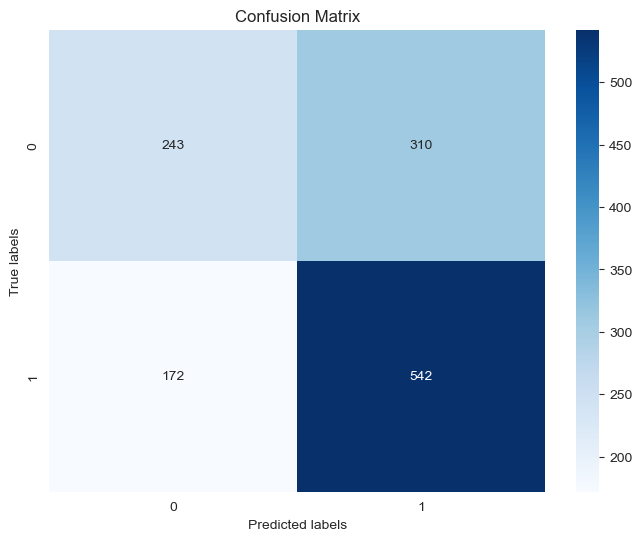

{'accuracy': 0.6195737963693765,
 'precision': 0.6140616313202385,
 'recall': 0.6195737963693765,
 'f1': 0.6092187133987305}

In [59]:
# evaluate best_model_bilstm_gru_spacy_pfine_dfine_binary and make prediction and plot confusion matrix
evaluation = bilstm_gru_model_spacy_pfine_dfine_binary.evaluate([X_test_spacy, X_test_pos_fine, X_test_dep_fine], Y_test_binary)
best_model_bilstm_gru_spacy_pfine_dfine_binary = load_model('best_model_bilstm_gru_spacy_pfine_dfine_binary')

bilstm_gru_spacy_pfine_dfine_binary_predictions = best_model_bilstm_gru_spacy_pfine_dfine_binary.predict([X_test_spacy, X_test_pos_fine, X_test_dep_fine])
plot_matrix_binary(bilstm_gru_spacy_pfine_dfine_binary_predictions)